# I. Introduction

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h2 align="center">1. Définition du problème</div>

L'objectif du projet est de développer un modèle de classification de
produits e-commerce pour la place de marché Rakuten, capable de prédire un code produit à partir de données multimodales :
- texte(catégories et description produits),
- images associées.

Cette classification est utile pour :
- exploiter efficacement le contenu fourni par les vendeurs,
- éviter les doublons,
- faciliter la gestion du catalogue,
- améliorer la recommandation et la personnalisation du parcours
utilisateur.

Ce projet s'inscrit dans le cadre du challenge :
**https://challengedata.ens.fr/challenges/35**


Dans ce document, nous chercherons à:
- comprendre le jeu de données,
- nettoyer le texte,
- analyser les differentes catégories,
- détecter les doublons et biais,
- créer des features et vérifier si elles sont pertinentes.

<div style="background:#fff3cd; padding:12px; border-left:6px solid #ffdd57; border-radius:4px">
⚠️ Ce notebook est <b>exclusivement dédié au traitement du texte</b>.  
L’analyse des images sera réalisée séparément dans un autre notebook.
</div>  


</br>
</br>
<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h2 align="center">2. Description du jeu de données</div>


Les données sont composées de :

• Fichiers CSV

-   **X_train.csv** : données d'entraînement (84 916 produits)
-   **Y_train.csv** : labels associés
-   **X_test.csv** : données de test (13 812 produits)


• Images

Un dossier compressé qui contient :
- **image_training**
- **image_test**
</br>
</br>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h2 align="center"> 3. Structure du dataset </div>

-   Données multimodales : texte + image
-   Données bruitées
-   Classes nombreuses (27)
-   Taille importante (près de 85 000 produits)
</br>
</br>


# II. Exploration initiale

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

La première étape consiste à préparer l'environnement Python du notebook, explorer et nettoyer les données textuelles du challenge <b>Rakuten France Product Data Classification</b>.

Notre objectif principal est de préparer un corpus textuel propre, cohérent et directement exploitable pour la vectorisation (TF-IDF, embeddings, modèles ML/DL) mais aussi:

- d' analyser la structure et la qualité des colonnes textuelles (<code>designation</code>, <code>description</code>) ;
- d' identifier les valeurs manquantes et les incohérences ;
- de nettoyer, normaliser et homogénéiser les textes ;
- de comprendre la distribution lexicale globale et par catégorie ;
- de construire un pré-traitement complet, reproductible et exploitable ;
- de produire un dataset textuel propre, prêt pour la modélisation.



<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h2 align="center"> 2.1 Imports et configuration</div></br></br>
Objectif : importer toutes les bibliothèques nécessaires pour l'analyse et la création de features.




In [ ]:
import regex as reg
import unicodedata
import os, re, json, html, base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import nltk
nltk.download('stopwords')
import nltk
import ftfy
from ftfy import fix_text
from collections import Counter
from pathlib import Path
from collections import Counter
from IPython.display import HTML, display
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from matplotlib.ticker import PercentFormatter
from nltk.corpus import stopwords
from IPython.display import HTML



[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h2 align="center">2.2 Chargement des données et aperçu initial</h2>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- préparer un aperçu global en HTML avec image :
- scanner les fichiers images, les associe aux 'imageid' du DataFrame via une 'lookup' (dictionnaire),
- convertir les images en HTML pour les afficher dans la table,

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- fusionner la designation et la description à <code>text</code>.

</br>
<div style="background:#f0f8ff; padding:12px; border-radius:6px">
a) Récupération des trois fichiers nécessaires à l'entraînement</div></br></br>
- <code>X_train_update.csv</code> contenant les textes bruts (informations produits),
- <code>Y_train_CVw08PX.csv</code> contenant la cible, les labels de chaque produits: <code>prdtypecode</code>,
- <code>image_train.csv</code> contenant les images de chaque produits.

---




In [ ]:
X_train = pd.read_csv("X_train_update.csv").drop("Unnamed: 0", axis=1)
Y_train = pd.read_csv("Y_train_CVw08PX.csv")['prdtypecode']
IMG_DIR  = "images/images/image_train"


In [ ]:
X_train.head()

designation  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4                               La Guerre Des Tuques   

                                         description   productid     imageid  
0                                                NaN  3804725264  1263597046  
1                                                NaN   436067568  1008141237  
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978  
3                                                NaN    50418756   457047496  
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786

In [ ]:
# Fusion de X_train et Y_train dans un seul DataFrame 'df' en se basant sur leurs index.
df = pd.concat([Y_train, X_train], axis=1)


In [ ]:
# fonction qui permet d'afficher les images du dataframe à partir du chemin des images
def display_df(df, max_length = 100):
    formatters={
        "image": lambda path: f'<img src="{path}" width="250">',
    }
    display(HTML(df.head(max_length).to_html(escape=False, formatters=formatters)))

<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Premier aperçu de df</div>


In [ ]:
print(df.info())
display(df.head())
print(f"La variable cible a {df["prdtypecode"].nunique()} modalités différentes.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prdtypecode  84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB
None


prdtypecode                                        designation  \
0           10  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1         2280  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2           50  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3         1280  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4         2705                               La Guerre Des Tuques   

                                         description   productid     imageid  
0                                                NaN  3804725264  1263597046  
1                                                NaN   436067568  1008141237  
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978  
3                                                NaN    50418756   457047496  
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786

La variable cible a 27 modalités différentes.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h2 align="center">2.3. Observation générale de df</h2>

<p align="center">Visualisation de la structure de données et repérage de premiers signaux faibles (valeurs manquantes, déséquilibre des classes etc.) </p>.</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

a) Affichage dans un premier temps de quelques lignes avec `head()` et utilisation de `info()`</div>
</br>
Nous allons vérifier le le nombre de lignes et de colonnes ainsi que le type de donnée.

In [ ]:
X_train.info()
print("="*40)
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.6+ MB
<class 'pandas.core.series.Series'>
RangeIndex: 84916 entries, 0 to 84915
Series name: prdtypecode
Non-Null Count  Dtype
--------------  -----
84916 non-null  int64
dtypes: int64(1)
memory usage: 663.5 KB


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

b) Sélection de 5 exemples (lignes) au hasard dans X_train pour inspection.

In [ ]:
#'random_state=42' assure que cet échantillon aléatoire est toujours le même
X_sample = X_train.sample(5, random_state=42)
Y_sample = Y_train.sample(5, random_state=42)
display(X_sample)

designation  \
36138              Nk Pro Racing - Jeu En Téléchargement   
68630                          Exit - Tombeau Du Pharaon   
36172  Bricolage Lettres En Mousse D'argent Alphabet ...   
9830   Nostalgique Fer Blanc Clockwork Chaîne Jouet P...   
28422  Le Courrier De L'unesco Mai 1996  N° 9605 : Le...   

                                             description   productid  \
36138  <strong>À PROPOS DU JEU</strong>  <b>NKPro Rac...  1711734527   
68630  <div class="rte"><p>EXIT est un jeu qui repren...  2397542298   
36172  Bricolage lettres en mousse d&#39;argent Alpha...  3979577549   
9830   Nostalgique fer blanc Clockwork chaîne Jouet P...  4197657726   
28422                                                NaN    52594358   

          imageid  
36138  1100082580  
68630  1139624392  
36172  1271697301  
9830   1313204688  
28422   518749844

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
c) Affichage de toutes les lignes de X_train qui contiennent au moins une valeur manquante (NaN).</div>

In [ ]:
display(X_train[X_train.isnull().any(axis=1)])

designation description  \
0      Olivia: Personalisiertes Notizbuch / 150 Seite...         NaN   
1      Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         NaN   
3      Peluche Donald - Europe - Disneyland 2000 (Mar...         NaN   
5      Afrique Contemporaine N° 212 Hiver 2004 - Doss...         NaN   
6             Christof E: Bildungsprozessen Auf Der Spur         NaN   
...                                                  ...         ...   
84898  Patrie Suisse (La) N° 136 Du 07/12/1898 - Alex...         NaN   
84900                         Mi Libro De Cortar Y Pegar         NaN   
84911                        The Sims [ Import Anglais ]         NaN   
84913  Journal Officiel De La Republique Francaise N°...         NaN   
84915  Gomme De Collection 2 Gommes Pinguin Glace Ver...         NaN   

        productid     imageid  
0      3804725264  1263597046  
1       436067568  1008141237  
3        50418756   457047496  
5         5862738   393356830  
6        91920807   907794536  
...           ...         ...  
84898   570634446  1027296807  
84900    85849076   895279629  
84911   206719094   941495734  
84913   440707564  1009325617  
84915    57203227   684671297  

[29800 rows x 4 columns]

<div style="background:#f0f8ff; padding:12px; border-radius:6px">d) Ajout des images produits au dataframe</div>
*   Reconstruction du chemin d'accès aux images à partir de la colonne imageid,
*   Ajout de la colonne image_path dans le dataframe,
*   Récupération du chemin de l'image dans la variable image,
*   Création d'un tableau pour l'affichage de quelques produits.


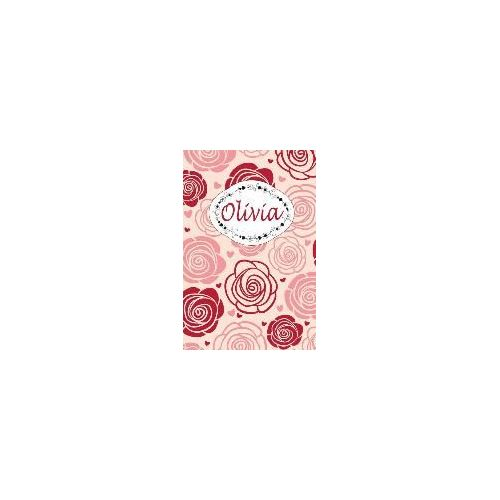

In [ ]:
IMG_DIR = Path("images/images/image_train")
files = list(IMG_DIR.glob("*.jpg"))
pat = re.compile(r"image_(\d+)_product_(\d+)\.jpg$")
lookup = {}
for p in files:
    m = pat.search(p.name)
    if m:
        lookup[m.group(1)] = p

df["image_path"] = df["imageid"].apply(lambda i: lookup.get(str(int(i))))

S = 256
def img_cell(p, size=S):
    if p is None or not Path(p).exists():
        return ""
    b64 = base64.b64encode(Path(p).read_bytes()).decode("ascii")
    return f'<img src="data:image/jpeg;base64,{b64}" />'

cols = ["prdtypecode","designation","description","imageid","image_path"]
view = df[cols].head(1).copy()
view["image"] = view["image_path"].apply(lambda p: img_cell(p, S))
view = view.drop(columns=["image_path"])

display(HTML(view.to_html(escape=False, index=True)))


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">2.4. Evaluation des descriptions manquantes</h2>

Objectif : comparer la disponibilité des descriptions et comprendre quelles catégories sont les plus affectées.
</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
a) Analyse des valeurs manquantes dans X_train </div></br>
- Affichage d'un aperçu des lignes avec des NaN, sélection d'un échantillon aléatoire (X et Y),
- calcul du taux de NaN global par colonne et affichage d'un taux spécifique pour la colonne 'description'.
- taux manquant de description

In [ ]:
no_description = X_train["description"].isna().mean()
print(f"Pourcentage de descriptions manquantes: {no_description:.2%}")

Pourcentage de descriptions manquantes: 35.09%


In [ ]:
no_designation = X_train["designation"].isna().mean()
display(f"Pourcentage de titres manquants: {no_designation:.2%}")

'Pourcentage de titres manquants: 0.00%'

Les produits n'ont pas toujours de description mais les designations ne sont jamais NaN tout comme les productid ou encore les imageid. <br><br>
<div style="background:#f0f8ff; padding:12px; border-radius:6px">
b) Vérification de l'unicité de chaque <b>productid</b> et <b>imageid</b></div>

In [ ]:
print(f"Il y a {df['productid'].duplicated(keep=False).sum()} duplicata pour productid.")
print(f"Il y a {df['imageid'].duplicated(keep=False).sum()} duplicata pour imageid.")


# on enregistre le chemin de l'image correspondant à chaque article dans une colonne image
df['image'] ="images/images/image_train/image_" + df['imageid'].astype('str') + '_product_' + df['productid'].astype('str') +'.jpg'

Il y a 0 duplicata pour productid.
Il y a 0 duplicata pour imageid.


In [ ]:
df['image'].head()

0    images/images/image_train/image_1263597046_pro...
1    images/images/image_train/image_1008141237_pro...
2    images/images/image_train/image_938777978_prod...
3    images/images/image_train/image_457047496_prod...
4    images/images/image_train/image_1077757786_pro...
Name: image, dtype: object

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

c) Calculer la proportion de descriptions manquantes par catégorie ('prdtypecode')

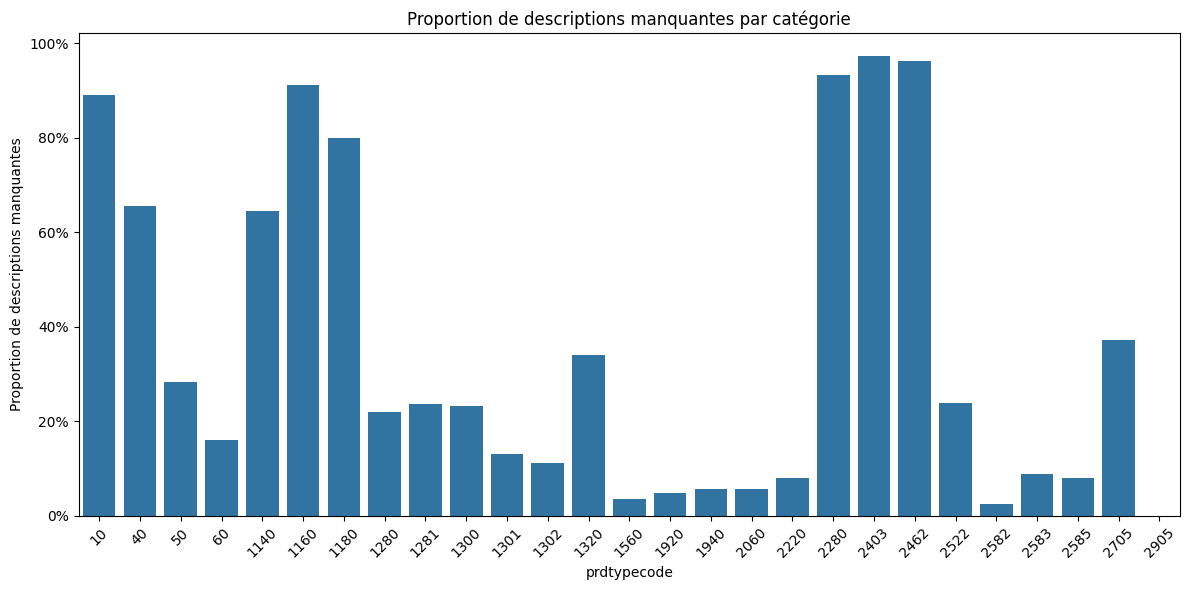

In [ ]:

missing_by_cat = (
    df.assign(description_isna=df["description"].isna())  # Ajoute une colonne True/False si la description est NaN
      .groupby("prdtypecode")["description_isna"]         # Regroupe par catégorie de produit
      .mean()                                             # Calcule le taux moyen de NaN (True=1, False=0)
      .reset_index(name="missing_ratio")                  # Convertit le résultat en DataFrame
)

# 2. Trier les catégories par taux de descriptions manquantes
missing_by_cat = missing_by_cat.sort_values("missing_ratio", ascending=False)

# Créer la figure pour le graphique
plt.figure(figsize=(12, 6))

# Créer le graphique en barres
sns.barplot(
    data=missing_by_cat,
    x="prdtypecode",
    y="missing_ratio"
)

# 3. Formater l'axe Y en pourcentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title("Proportion de descriptions manquantes par catégorie")
plt.xlabel("prdtypecode")
plt.ylabel("Proportion de descriptions manquantes")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Ce graphique démontre que la présence de description produit est très hétérogène. En effet, 6 catégories ont plus de 80% de descriptions manquantes, 8 catégories ont moins de 10% de descriptions manquantes.
Pour la détection des catégories possedant peu de description produit, , il faudra s’appuyer principalement sur le titre et sur l’image produit.

Lors de la modélisation, il faudra prendre en compte le fait que la présence des descriptions n'est pas uniforme. Il y a un risque de biais, les catégories où la description est manquante dans plus de 80% des cas ne devront pas être pénalisées.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">d) Suppression de "imageid"</div>

Les productid sont tous uniques on peut donc réindexer df par cette colonne. Les imageid ne sont plus nécessaires maintenant qu'on a récupéré le chemin, on va donc supprimer la colonne imageid.

In [ ]:
df = df.set_index("productid").drop('imageid', axis=1)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">2.5. Fusion de la designation et de la description</h2>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

Étant donné que la colonne description présente plus de $35\%$ de valeurs manquantes, il est décidé de fusionner les deux colonnes afin de faciliter l'analyse et le nettoyage du texte.

In [ ]:
df["text"] = (df["designation"].fillna("") + " " + df["description"].fillna(""))

df.head()

prdtypecode                                        designation  \
productid                                                                    
3804725264           10  Olivia: Personalisiertes Notizbuch / 150 Seite...   
436067568          2280  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
201115110            50  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
50418756           1280  Peluche Donald - Europe - Disneyland 2000 (Mar...   
278535884          2705                               La Guerre Des Tuques   

                                                  description  \
productid                                                       
3804725264                                                NaN   
436067568                                                 NaN   
201115110   PILOT STYLE Touch Pen de marque Speedlink est ...   
50418756                                                  NaN   
278535884   Luc a des id&eacute;es de grandeur. Il veut or...   

                                                   image_path  \
productid                                                       
3804725264  images\images\image_train\image_1263597046_pro...   
436067568   images\images\image_train\image_1008141237_pro...   
201115110   images\images\image_train\image_938777978_prod...   
50418756    images\images\image_train\image_457047496_prod...   
278535884   images\images\image_train\image_1077757786_pro...   

                                                        image  \
productid                                                       
3804725264  images/images/image_train/image_1263597046_pro...   
436067568   images/images/image_train/image_1008141237_pro...   
201115110   images/images/image_train/image_938777978_prod...   
50418756    images/images/image_train/image_457047496_prod...   
278535884   images/images/image_train/image_1077757786_pro...   

                                                         text  
productid                                                      
3804725264  Olivia: Personalisiertes Notizbuch / 150 Seite...  
436067568   Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...  
201115110   Grand Stylet Ergonomique Bleu Gamepad Nintendo...  
50418756    Peluche Donald - Europe - Disneyland 2000 (Mar...  
278535884   La Guerre Des Tuques Luc a des id&eacute;es de...

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">3.1. Analyse des mots les plus fréquents</h2>

<div style="background:#fff3cd; padding:12px; border-left:6px solid #ffdd57; border-radius:4px">

Le modèle TF-IDF que nous utiliserons dans ce projet a une propriété clé :
il renforce le poids des termes rares et informatifs dans un document, tout en atténuant celui des mots très fréquents dans l’ensemble du corpus.
En effet, la frequence est prise en compte .
Dans cette logique, nous avons choisi de faire du nettoyage de mots à haute fréquence une étape centrale du pré-traitement.

En effet, les termes trop fréquents mais peu discriminants, autrement dit, le bruit, a tendance à diluer les signaux réellement utiles pour la classification.

Identifier et neutraliser ces mots (stopwords, formulations génériques, mentions systématiques mais non informatives, etc.) en amont permet de clarifier l’espace lexical et d’améliorer la capacité de TF-IDF à mettre en avant les caractéristiques vraiment pertinentes pour distinguer les catégories produits.

Il sera indispensable de ré-examiner les mots fréquents après le nettoyage pour pouvoir repérer les autres termes non pertinents.
trouver un moyen d'expliquer davantage l'importance du omt piscine avant nettoyage
</div>
    

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

a) Identifier et afficher les mots les plus fréquents dans le texte original.

In [ ]:
top_n = 40

def get_word_freq(series, top_n):
    # On récupère tous les mots
    all_words = []
    for text in series:
        if isinstance(text, str):
            all_words.extend(text.split())

    # On compte les fréquences sans Counter
    freq = {}
    for word in all_words:
        freq[word] = freq.get(word, 0) + 1

    # On trie par fréquence décroissante
    sorted_words = sorted(freq.items(), key=lambda x: x[1], reverse=True)

    # On garde seulement les top_n
    return sorted_words[:top_n]

freq_before = get_word_freq(df["text"], top_n=top_n)

print("=== Top words BEFORE cleaning ===")
for word, count in freq_before:
    print(f"{word}: {count}")

print(df.columns.tolist())


=== Top words BEFORE cleaning ===
de: 372883
et: 145462
la: 136102
à: 111695
pour: 84528
-: 80819
:: 79201
en: 78584
x: 69640
le: 69101
les: 66725
des: 51758
un: 46013
est: 44531
une: 41334
De: 39925
du: 39399
vous: 38690
avec: 38603
/>: 33990
1: 33813
votre: 31283
/: 30020
<br: 26820
dans: 25452
ou: 24868
sur: 24445
cm: 22995
pas: 21696
Le: 20464
La: 20364
plus: 20086
peut: 20084
2: 19762
que: 18200
au: 17353
haute: 15900
piscine: 15818
être: 15259
*: 15059
['prdtypecode', 'designation', 'description', 'image_path', 'image', 'text']


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Parmi ces mots les plus fréquents, la majorité sont des particules, des mots vides (mots grammaticaux) et autres termes sans signification en français, ainsi que des symboles de balisage HTML.
<br></br>
Il est également évident que certains mots sont très importants pour la classification, comme "piscine". Pour le prouver, examinons la fréquence d'apparition de "piscine" dans les différentes catégories, comme illustré ci-dessous :
</div>

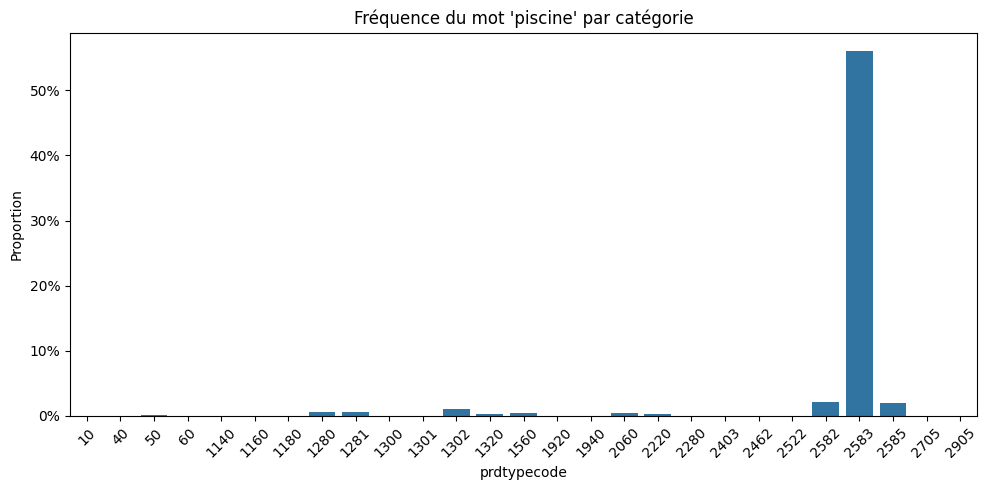

In [ ]:
def plot_keyword_per_category(df, keyword, text_col="text"):
    """
    Trace la fréquence d'un mot-clé par catégorie,
    sans modifier le DataFrame original (pas de colonne contains_word ajoutée).
    """
    # 1) Travailler sur une copie minimale
    temp = df[[text_col, "prdtypecode"]].copy()

    # 2) Créer la colonne booléenne sur la copie
    temp["contains_word"] = temp[text_col].str.contains(
        fr"\b{keyword}\b", na=False
    )

    # 3) Calculer la fréquence par catégorie
    freq = (
        temp.groupby("prdtypecode")["contains_word"]
            .mean()
            .reset_index()
    )

    # 4) Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=freq, x="prdtypecode", y="contains_word")
    plt.title(f"Fréquence du mot '{keyword}' par catégorie")
    plt.ylabel("Proportion")
    plt.xlabel("prdtypecode")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Exemple d'appel
plot_keyword_per_category(df, "piscine")


Nous constatons que pour une grande majorité de catégories la présence du mot "piscine" est quasi nulle. À l'inverse, une catégorie se distingue très nettement pour plus de 50% des produits, cela permet donc de distinguer une catégorie précise.

Deux catégories voisines ont un faible pourcentage de produits(moins de 5%) contenant le mot piscine, il pourrait s'agir d'accessoires ou d'entretien.

Nous avons donc une variable liée à un mot clé permettant de distinger très fortement une catégorie après nettoyage du texte.

# III. Nettoyage du texte


En regardant les designations et les descriptions, on peut remarquer que certains textes comportent des balises html, des entitées html et des caractères qui semblent mals encodés. Nous allons donc écrire une fonction permettant de nettoyer le texte à l'aide des librairies regex, html (pour traîter les entités html), ftfy et unicodedata (pour la gestion de l'encodage).

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">3.1 Suppression des balises HTML, des symboles isolés et des espaces excédentaires.</h3>

Pipeline de nettoyage de base (lowercase, suppression HTML, ponctuation superflue, etc.).

In [ ]:
# Fonction pour nettoyer et standardiser les données textuelles:
def nettoyer_texte(text):
    if pd.isna(text):
        return ""
    s = str(text)
    s = reg.sub(r"<[^>]+>", " ", s)          # Supprime HTML
    s = html.unescape(s)                     # Décode entités HTML
    s = ftfy.fix_text(s)                     # Corrige le texte cassé
    s = unicodedata.normalize("NFC", s)      # Normalise Unicode
    s = reg.sub(r"(?<!\d)\.(?!\d)", " ", s)  # Supprime les points non numériques
    s = reg.sub(r"(?<!\S)-(?!\S)", " ", s)   # Supprime les tirets isolés
    s = reg.sub(r"(?<!\S):(?!\S)", " ", s)   # Supprime les deux-points isolés
    s = reg.sub(r"(?<!\S)·(?!\S)", " ", s)   # Supprime les points médians isolés
    s = reg.sub(r"(?<!\S)/(?!\S)", " ", s)   # Supprime le slash isolé
    s = reg.sub(r"(?<!\S)\+(?!\S)", " ", s)  # Supprime le plus isolé
    s = s.replace("////", " ")
    s = reg.sub(r"\s+", " ", s).strip().lower()     # Nettoie espaces et casses
    return s

# Le texte de ce produit rencontre les problèmes décrits nous allons donc tester la fonction de nettoyage ci-dessus
productid = 4

description = df.iloc[14]['description']

print(f"--- productid {productid} [texte original] ---")
print(description)
print("\n" + "="*40 + "\n")
print(f"--- productid {productid} [texte nettoyé] ---")
print(nettoyer_texte(description))

--- productid 4 [texte original] ---
MATELAS:<br />Â· Accueil : Ferme .<br />Â· Soutien : Très Ferme .<br />Â· Technologie matelas : Face été &#43; à¢me en Mousse Poli Lattex Dernière Génération Indéformable Très Haute Résilience - Face Hiver 45 cm de Mousse à  Mémoire de Forme Très Haute Densité 60 Kg/m3 &#34; Massante&#34;<br />Â· Épaisseur du matelas : &#43;/- 20 cm.<br />Â· REPOS PLUS SAIN grà¢ce au Traitement Anti-acariens / anti-bactérien / Anti-moisissures.<br />Â· Très Bonne Indépendance de couchage.<br />Â· DORMEZ TRANQUILLE avec la Garantie 5 ans.  Il est Compatible avec les Sommiers Mécaniques et électriques<br />Coutil:<br />Â· Coutil stretch matelassé de 290 gr/m2 de Polyester avec traitement Sanitized. Faces de couchage Réversibles - Déhoussable sur 3 Cà¿tés et Housse Lavable à  30Â° position Lavage à  la main Délicat -<br />Â· SANITIZED : Traitement antibactérien et anti-moisissures diminuant également le développement des odeurs.<br />Structure et garnissage du matelas:

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">3.2 Échantillon d'un texte nettoyé pour comparaison</h3>

In [ ]:
index_to_check = 36138
original_text = df.iloc[index_to_check][ 'text']
cleaned_text = nettoyer_texte(original_text)

print(f"--- Index {index_to_check} [text original] ---")
print(original_text)
print("\n" + "="*40 + "\n")
print(f"--- Index {index_to_check} [text cleaned] ---")
print(cleaned_text)


--- Index 36138 [text original] ---
Nk Pro Racing - Jeu En Téléchargement <strong>À PROPOS DU JEU</strong>  <b>NKPro Racing</b> dispose d&#39;un moteur physique de pointe. Cette expérience de conduite hyperréaliste prend également en compte les conditions météorologiques comme la simulation de l&#39;aquaplaning pour des courses plus vraies que nature. <br /><br /> Vivez une expérience de conduite hyperréaliste avec les changements de météo qui affectent les conditions de course les cockpits interactifs et les écrans de télémétrie qui fournissent les données précises et les analyses des courses. Retrouvez 9 catégories de voitures prototypes (monoplaces et GT) un mode multijoueur jusqu&#39;à 15 un éditeur de circuits qui permet à la communauté en ligne de créer et de télécharger leurs propres pistes? NKPro Racing est le simulateur de course ULTIME! <br /><br /><br /> <strong>CARACTÉRISTIQUES</strong>  <ul><li>jeu de course ultra-réaliste</li><li><br /> </li><li>Conduite sous la pluie</li

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">3.3 Préparation du vocabulaire et des mots vides en français et anglais</h3>




<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
Pour les éléments linguistiques tels que les articles, les prépositions, les conjonctions et les pronoms en français et en anglais, le NLTK (Natural Language Toolkit) propose une bibliothèque de mots vides (stopwords) qui peut facilement nous aider à filtrer ces termes. Utilisons cette bibliothèque pour nettoyer ces éléments linguistiques non significatifs.

In [ ]:
nltk.download('stopwords')
NLTK_STOPS = set(stopwords.words("french")) | set(stopwords.words("english"))

def nltk_stopwords(text: str, stopwords_set=None):
    if stopwords_set is None:
        stopwords_set = set()
    if not isinstance(text, str):
        return []

    tokens = []
    for w in text.split():
        w = w.lower()
        if w in stopwords_set:
            continue
        tokens.append(w)
    return tokens


def get_word_freq_with_nltk_stopwords(series, stopwords_set=None):
    all_tokens = []
    for text in series:
        all_tokens.extend(nltk_stopwords(text, stopwords_set))
    return Counter(all_tokens)


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


<div style="background:#f0f8ff; padding:12px; border-radius:6px"><h3 align="center">3.4. Analyse lexicale et n-grammes</div>

À partir du texte nettoyé et du vocabulaire filtré (stopwords FR/EN, normalisation, etc.) l'objectif est de:

*   comprendre quelles associations de mots (bigrams, trigrams) reviennent le plus souvent,
*   identifier des expressions spécifiques de certaines catégories produits,
*   préparer des features candidates basées sur ces n-grammes (variables indicatrices, enrichissement du vocabulaire TF-IDF, etc.).




<div style="background:#f0f8ff; padding:12px; border-radius:6px">

a) Identification des bigrams et des trigrams *dominants*

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

L'extraction de N-grams via CountVectorizer permet d'identifier des séquences de mots ou expressions fréquemment co-occurrentes qui portent un sens spécifique dans le corpus. Cette analyse est cruciale pour révéler des thèmes, des relations contextuelles ou des motifs linguistiques que les mots individuels ne peuvent pas montrer offrant ainsi des informations précieuses pour la modélisation et l'ingénierie des caractéristiques du texte.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2,2), top_n=10):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=5)
    X = vec.fit_transform(corpus)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    df = pd.DataFrame(freqs, columns=["ngram", "count"])
    return df.sort_values(by="count", ascending=False).head(top_n)

corpus = df["text"].astype(str).tolist()

print("Top 10 bigrams:")
display(get_top_ngrams(corpus, ngram_range=(2,2), top_n=10))

print("\nTop 10 trigrams:")
display(get_top_ngrams(corpus, ngram_range=(3,3), top_n=10))

Top 10 bigrams:


ngram  count
46789           de la  46986
91785           li li  45585
44974           de 39  24376
27214           br br  20373
64328           et de  15259
7019           39 eau  15114
46645        de haute  10851
7332            39 il  10497
120141       pour les  10314
76654   haute qualité  10153


Top 10 trigrams:


Nous constatons que la majorité des n-grammes les plus fréquents ne sont pas des expressions utiles, seuls quelques n-grammes sont réellement informatifs (ex:haute qualité). La présence de buit demeure importante. Le texte a donc besoin d'être mieux nettoyé. Nous allons donc poursuivre le nettoyage du texte pour aider à la classification.



<div style="background:#f0f8ff; padding:12px; border-radius:6px">

b) Élaboration d’une première liste d’expressions à surveiller

Nous établissons manuellement une liste d'expressions fréquentes qui sera enrichie et ajustée de manière itérative lors des phases de nettoyage suivantes.
</div>

In [ ]:
# boilerplate phrase list
BOILERPLATE_PHRASES = ["de haute qualite", "haute qualite", "il vous plait", "vous plait", "vous plait permettre", "peut etre", "peut etre legerement", "peut etre utilise", "etre legerement different",
    "raison de la", "en raison", "en raison de", "raison de", "la couleur reelle", "couleur reelle de", "couleur reelle", "la couleur et", "la couleur de", "la mesure", "la mesure manuelle",
    "de la mesure", "la difference", "de la difference", "la lumiere", "de la lumiere", "ne pas", "ne pas utiliser", "ne pas refleter", "ne pas reflecter", "ne sont pas", "pas refleter la",
        "pas reflecter la", "plait permettre une", "la marque", "de la marque", "la main", "tout neuf", "100 tout neuf", "neuf et", "neuf et de", "tout neuf et", "forfait comprend",
    "le forfait comprend", "le forfait", "contenu de emballage", "contenu du coffret", "le paquet contient", "de element peut", "element peut etre", "permettre une legere", "duree de vie",
    "different des images", "en fonction de",]

def remove_boilerplate_phrases(s: str) -> str:
    if not s:
        return s
    out = s
    for phrase in BOILERPLATE_PHRASES:
        out = out.replace(phrase, " ")
    return out


c) Mise en place d' une liste personnalisée de mots vides stop words en fonction de la distribution des mots et des expressions dans les différentes catégories.

In [ ]:
MY_STOPWORDS: set[str] = {"qualite", "neuf", "nouveau", "s'il", "d'un", "d'une", "ect", "m?", "plus", "peut", "etre", "être", "comme", "cette", "tout", "tous","tres", "très", "si", "aussi", "encore", "peu", "egalement", "également","avant", "entre", "grace", "grâce","pour", "dans", "ce", "ces", "dont", "depuis","ainsi", "son", "leurs", "avec","100%","facile","vraiment", "simplement", "entierement", "completement","deja", "juste","description:", "caractéristiques:", "caractéristiques","contenu", "type", "etc","utiliser", "utilisé", "utilise", "utilisés", "utilises","fait", "faire", "permet", "permettre", "peuvent", "parfait", "ideal", "idéal", "grand", "grande", "different", "différent", "differents", "différents", "durable","facile"}


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">
3.5 Fonction de normalisation des dimensions physiques.</h3>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

L'objectif est de fusionner les motifs numériques décrivant des tailles (ex: "22 x 11") en un seul token (ex: "22x11"). Cela permettra au modèle de traiter les dimensions comme une entité unique plutôt que comme des nombres et des lettres séparés.

In [ ]:
def merge_x_dimensions(text):
    """
    Normalize dimension patterns like:
      - '22 x 11 x 2' -> '22x11x2'
      - '180 x 180'   -> '180x180'
      - 'L x H x L'   -> 'LxHxL'
    """
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return ""
    s = str(text)

    # 1) numeric triplets: 22 x 11 x 2 → 22x11x2
    s = re.sub(r"\b(\d+)\s*[xX]\s*(\d+)\s*[xX]\s*(\d+)\b", r"\1x\2x\3", s)

    # 2) numeric pairs: 180 x 180 → 180x180
    s = re.sub(r"\b(\d+)\s*[xX]\s*(\d+)\b", r"\1x\2", s)

    # 3) letter triplets: L x H x L → LxHxL
    s = re.sub(r"\b([LlHh])\s*[xX]\s*([LlHh])\s*[xX]\s*([LlHh])\b", r"\1x\2x\3", s)

    return s



<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">3.6 Fonctions utilitaires de filtrage du bruit résiduel</h3>

Nous allons définir quelques fonctions utilitaires pour repérer rapidement des portions de texte peu informatifs:

- les lettres isolées (`is_single_letter`) ;
- les chiffres isolés (`is_single_digit`) ;
- les tokens composés uniquement de ponctuation (`is_pure_punctuation`), en utilisant un jeu étendu de caractères de ponctuation (`PUNCT_CHARS`).

Ces fonctions seront réutilisées dans les étapes suivantes pour concentrer l’analyse sur les tokens porteurs de sens.

In [ ]:
import string

PUNCT_CHARS = set(string.punctuation) | {"…", "’", "“", "”", "«", "»"}

def is_single_letter(token: str) -> bool:
    return len(token) == 1 and token.isalpha()

def is_single_digit(token: str) -> bool:
    return len(token) == 1 and token.isdigit()

def is_pure_punctuation(token: str) -> bool:
    if not token:
        return False
    return all(ch in PUNCT_CHARS for ch in token)


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">3.7 Fonction maîtresse de nettoyage</h3>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

Fonction de nettoyage unifiée avec des indicateurs pour chaque étape.
    
    
       - text (str): Le texte brut à nettoyer.
       - use_basic_cleaning (bool): Active le nettoyage regex (HTML, ponctuation, minuscules).
       - remove_boilerplate (bool): Active la suppression des phrases récurrentes (BOILERPLATE_PHRASES).
       - remove_nltk_stops (bool): Active la suppression des stopwords NLTK (français + anglais).
       - remove_custom_stops (bool): Active la suppression des stopwords métier (MY_STOPWORDS).
       - Stopwords + single-letter/digit + punctuation
       - nettoyer les espaces multiples
    

In [ ]:
def global_text_cleaner(
    text,
    use_basic_cleaning: bool = True,
    normalize_x_dimensions: bool = True,
    remove_boilerplate: bool = True,
    remove_nltk_stops: bool = True,
    remove_custom_stops: bool = True,
    remove_single_digit: bool = True,
    remove_single_letter: bool = True
):
    if pd.isna(text) or text is None:
        return ""

    # ---- Étape 1 : Nettoyage de base (HTML, Regex, normalisation) ----
    s = str(text)

    if normalize_x_dimensions:
        s = merge_x_dimensions(s)

    if use_basic_cleaning:
        s = reg.sub(r"<[^>]+>", " ", s)          # Remove HTML
        s = html.unescape(s)                     # Decode HTML entities
        s = fix_text(s)                          # Fix broken text
        s = unicodedata.normalize("NFC", s)      # Normalize Unicode

        # Keep decimal points in numbers, remove others
        s = reg.sub(r"(?<!\d)\.(?!\d)", " ", s)

        # Remove isolated hyphens / colons / middle dots / slashes / plus signs
        s = reg.sub(r"(?<!\S)-(?!\S)", " ", s)
        s = reg.sub(r"(?<!\S):(?!\S)", " ", s)
        s = reg.sub(r"(?<!\S)·(?!\S)", " ", s)
        s = reg.sub(r"(?<!\S)/(?!\S)", " ", s)
        s = reg.sub(r"(?<!\S)\+(?!\S)", " ", s)
        s = s.replace("////", " ")

        # Lowercase at the end of basic cleaning
        s = s.lower()

    # ---- Étape 2 : Suppression des phrases "boilerplate" ----
    if remove_boilerplate and "BOILERPLATE_PHRASES" in globals():
        for phrase in BOILERPLATE_PHRASES:
            s = s.replace(phrase, " ")

    # ---- Étape 3 : Stopwords + single-letter/digit + punctuation ----
    if remove_nltk_stops or remove_custom_stops or remove_single_digit or remove_single_letter:
        tokens = s.split()

        # Build the ban list
        stops_to_exclude = set()
        if remove_nltk_stops and "NLTK_STOPS" in globals():
            stops_to_exclude.update(NLTK_STOPS)
        if remove_custom_stops and "MY_STOPWORDS" in globals():
            stops_to_exclude.update(MY_STOPWORDS)

        filtered = []
        for w in tokens:
            # skip if in stopword list
            if w in stops_to_exclude:
                continue
            # skip pure punctuation tokens like "*", "???", ":", "(l"
            if is_pure_punctuation(w):
                continue
            # optional: skip single letters
            if remove_single_letter and is_single_letter(w):
                continue
            # optional: skip single digits
            if remove_single_digit and is_single_digit(w):
                continue

            filtered.append(w)

        s = " ".join(filtered)

    # ---- Étape finale : nettoyer les espaces multiples ----
    s = reg.sub(r"\s+", " ", s).strip()
    return s


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">3.8 Exécution du nettoyage **complet** et comparaison</h3>

Nous allons activer le pipeline de nettoyage sur l'ensemble du texte. Ce pré-traitement nous permettra d'avoir un texte plus propre, plus homogène, prêt pour les étapes de modélisation.

In [ ]:
# 1. Application du nettoyage complet sur tout le dataframe
print("Début du nettoyage complet du corpus...")
df["text_clean"] = df["text"].apply(lambda x: global_text_cleaner(
    x,
    use_basic_cleaning=True,
    remove_boilerplate=True,
    remove_nltk_stops=True,
    remove_custom_stops=True,
    remove_single_digit=True,
    remove_single_letter=True
))
print("Nettoyage terminé.")

# 2. Comparaison sur l'exemple à la position 505 (ou la dernière ligne si le df est plus petit)
idx_example = 505
if idx_example >= len(df):
    idx_example = len(df) - 1  # on prend la dernière ligne disponible

print(f"\n{'='*20} COMPARAISON AVANT / APRÈS (Ligne {idx_example}) {'='*20}")
print(f"[ORIGINAL]:\n{df.iloc[idx_example]['text'][:300]}...")
print(f"\n[CLEANED]:\n{df.iloc[idx_example]['text_clean'][:300]}...")

# 3. Analyse des mots les plus fréquents APRES nettoyage complet
print(f"\n{'='*20} TOP 40 MOTS APRÈS NETTOYAGE COMPLET {'='*20}")
freq_after = get_word_freq(df["text_clean"], top_n=40)
for mot, freq in freq_after:
    print(f"{mot:<15} {freq}")


Début du nettoyage complet du corpus...


Les comparaisons nous permettent de constater que le texte est devenu plus homogène, tout en minuscule et sans caractères spéciaux superflue.
Les mots fréquents sont maintenant liés en grande partie à des caractéristiques produits: mesures et unités, attributs etc.
Ce pipeline a donc permis de mettre en avant les termes pertinents des produits.

Après l'ajout de stopwords complémentaires, le top 40 des mots les plus fréquent est presque composé de termes produits uniquement ou d'éléments techniques. Le vocabulaire contient des informations pertinentes pour la classification.


# IV. Détection de doublons


Avoir plusieurs vendeurs sur une plateforme peut causer des fiches produits répétitives avec des descriptions identiques ou proches avec reformulation.
Ces doublons introduisent un biais important dans l'analyse de données d'où l'importance de les supprimer.

L'objectif de cette partie est de construire un pipeline robuste de détection de doublons basé sur:
*  l'uniformisation du texte,
*  des mesures de similarité textuelle,
*  la détection de groupes de descriptions proches,
*  l'identification des occurences à conserver et celles à exclure.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">
4.1 Nettoyage séparé de la désignation et de la description
</h3>
</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">a) Application du pipeline de nettoyage aux titres et descriptions produit</div>

Nettoyer séparément la désignation et la description permet de préserver la structure du texte, traiter les bruits spécifiques à chaque champ, gérer les descriptions manquantes et produire un champ final homogène pour la modélisation.

In [ ]:
df["designation_cleaned"] = df["designation"].fillna("").apply(
    lambda x: global_text_cleaner(
        x,
        use_basic_cleaning=True,
        remove_boilerplate=True,
        remove_nltk_stops=True,
        remove_custom_stops=True,
        remove_single_digit=True,
        remove_single_letter=True
    )
)

df["description_cleaned"] = df["description"].fillna("").apply(
    lambda x: global_text_cleaner(
        x,
        use_basic_cleaning=True,
        remove_boilerplate=True,
        remove_nltk_stops=True,
        remove_custom_stops=True,
        remove_single_digit=True,
        remove_single_letter=True
    )
)


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

b) Création du texte final pour le modèle (Concaténation Titre + Description)

In [ ]:
# 2) Texte final pour le modèle (titre + description)
df["text_clean"] = (
    df["designation_cleaned"].str.strip()
    + " "
    + df["description_cleaned"].str.strip()
).str.strip()

In [ ]:
df.head(2)

prdtypecode                                        designation  \
productid                                                                    
3804725264           10  Olivia: Personalisiertes Notizbuch / 150 Seite...   
436067568          2280  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   

           description                                         image_path  \
productid                                                                   
3804725264         NaN  images\images\image_train\image_1263597046_pro...   
436067568          NaN  images\images\image_train\image_1008141237_pro...   

                                                        image  \
productid                                                       
3804725264  images/images/image_train/image_1263597046_pro...   
436067568   images/images/image_train/image_1008141237_pro...   

                                                         text  \
productid                                                       
3804725264  Olivia: Personalisiertes Notizbuch / 150 Seite...   
436067568   Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   

                                                   text_clean  \
productid                                                       
3804725264  olivia: personalisiertes notizbuch 150 seiten ...   
436067568   journal arts (le) n° 133 28/09/2001 l'art marc...   

                                          designation_cleaned  \
productid                                                       
3804725264  olivia: personalisiertes notizbuch 150 seiten ...   
436067568   journal arts (le) n° 133 28/09/2001 l'art marc...   

           description_cleaned  
productid                       
3804725264                      
436067568

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

c) Détection des doublons par groupe (designation_cleaned, description_cleaned
et calcul du nombre d'occurrences pour identifier les fuites de données potentielles

In [ ]:
dup_counts = (
    df.groupby(["designation_cleaned", "description_cleaned"])
      .size()
      .rename("dup_count")
)

df = df.join(dup_counts, on=["designation_cleaned", "description_cleaned"])
df["is_duplicated_group"] = df["dup_count"] > 1

df[["designation_cleaned", "description_cleaned", "dup_count", "is_duplicated_group"]].head()


designation_cleaned  \
productid                                                       
3804725264  olivia: personalisiertes notizbuch 150 seiten ...   
436067568   journal arts (le) n° 133 28/09/2001 l'art marc...   
201115110   stylet ergonomique bleu gamepad nintendo wii s...   
50418756    peluche donald europe disneyland 2000 (marionn...   
278535884                                       guerre tuques   

                                          description_cleaned  dup_count  \
productid                                                                  
3804725264                                                             1   
436067568                                                              1   
201115110   pilot style touch pen marque speedlink stylet ...          1   
50418756                                                               1   
278535884   luc idées grandeur veut organiser jeu guerre b...          1   

            is_duplicated_group  
productid                        
3804725264                False  
436067568                 False  
201115110                 False  
50418756                  False  
278535884                 False

In [ ]:
print(f"Avant nettoyage il y a {df[["designation", "description", "prdtypecode"]].duplicated(keep=False).sum()} duplicata(s) textuels.")
print(f"Après nettoyage il y a {df[["designation_cleaned", "description_cleaned", "prdtypecode"]].duplicated(keep=False).sum()} duplicata(s) textuels.")

Avant nettoyage il y a 2311 duplicata(s) textuels.
Après nettoyage il y a 2669 duplicata(s) textuels.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">
4.2 Doublons (texte + image)
</h3>
</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">a) Hashage des images produit</div>

Pour identifier les lignes qui sont de véritables doublons, il faudrait vérifier qu'en plus d'avoir une designation et une description identique, qu'elles aient des images identiques.

Pour comparer les images nous allons utiliser la méthode de hashage (hash) afin d' attribuer un identifiant à chaque photo.  
Si deux photos sont identiques, cet identifiant sera répété, sinon, si deux images sont différentes, leurs identifiants seront différents.

In [ ]:
# génère le hashage en fonction d'une liste de chemins

import hashlib

def generate_hash(paths):
    hashed_contents = []
    for path in paths:
        with open(path, 'rb') as f:
            hashed_contents.append(hashlib.sha1(f.read()).hexdigest())  # on récupère le contenu du fichier puis on le hash
    return hashed_contents

df['hashed_image'] = generate_hash(df['image'])

<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Suppression de doublons texte + image</div>

In [ ]:
n_duplicates = df[['designation_cleaned', 'description_cleaned', 'hashed_image', 'prdtypecode']].duplicated(keep=False).sum()
print(f"Il y a {n_duplicates} duplicata(s). Ce qui correspond à {round((n_duplicates/len(df))*100, 1)} % des produits.")
df = df.drop_duplicates(subset=['designation_cleaned', 'description_cleaned', 'hashed_image', 'prdtypecode'])


Il y a 754 duplicata(s). Ce qui correspond à 0.9 % des produits.


In [ ]:
n_duplicata_wdiff_prdtypecode = df[['designation_cleaned', 'description_cleaned', 'hashed_image']].duplicated(keep=False).sum()
print(f"Il y a {n_duplicata_wdiff_prdtypecode} lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.")

Il y a 20 lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

c) Construction du DataFrame complet contenant les données brutes, les données nettoyées et les métadonnées de doublons

In [ ]:
df.columns.tolist()


['prdtypecode',
 'designation',
 'description',
 'image_path',
 'image',
 'text',
 'text_clean',
 'designation_cleaned',
 'description_cleaned',
 'dup_count',
 'is_duplicated_group',
 'hashed_image']

In [ ]:
cols_full_export = [
    # "productid",
    #"imageid",
    "prdtypecode",
    "designation",
    "description",
    "designation_cleaned",
    "description_cleaned",
    "text_clean",
    "dup_count",
    "is_duplicated_group",
]

df_full_export = df[cols_full_export].copy()

df_full_export.head()



prdtypecode                                        designation  \
productid                                                                    
3804725264           10  Olivia: Personalisiertes Notizbuch / 150 Seite...   
436067568          2280  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
201115110            50  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
50418756           1280  Peluche Donald - Europe - Disneyland 2000 (Mar...   
278535884          2705                               La Guerre Des Tuques   

                                                  description  \
productid                                                       
3804725264                                                NaN   
436067568                                                 NaN   
201115110   PILOT STYLE Touch Pen de marque Speedlink est ...   
50418756                                                  NaN   
278535884   Luc a des id&eacute;es de grandeur. Il veut or...   

                                          designation_cleaned  \
productid                                                       
3804725264  olivia: personalisiertes notizbuch 150 seiten ...   
436067568   journal arts (le) n° 133 28/09/2001 l'art marc...   
201115110   stylet ergonomique bleu gamepad nintendo wii s...   
50418756    peluche donald europe disneyland 2000 (marionn...   
278535884                                       guerre tuques   

                                          description_cleaned  \
productid                                                       
3804725264                                                      
436067568                                                       
201115110   pilot style touch pen marque speedlink stylet ...   
50418756                                                        
278535884   luc idées grandeur veut organiser jeu guerre b...   

                                                   text_clean  dup_count  \
productid                                                                  
3804725264  olivia: personalisiertes notizbuch 150 seiten ...          1   
436067568   journal arts (le) n° 133 28/09/2001 l'art marc...          1   
201115110   stylet ergonomique bleu gamepad nintendo wii s...          1   
50418756    peluche donald europe disneyland 2000 (marionn...          1   
278535884   guerre tuques luc idées grandeur veut organise...          1   

            is_duplicated_group  
productid                        
3804725264                False  
436067568                 False  
201115110                 False  
50418756                  False  
278535884                 False

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

d)Export du jeu de données complet</div>

In [ ]:
df_full_export.to_csv("rakuten_text_clean_full_v1.csv", index=False)




<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h3 align="center">
4.3 Analyse des potentiels doublons
</h3>
</div>



Dans le jeu de donnée il semble y avoir beaucoup de doublons de produits où seule une petite modification du texte a été apportée. Nous allons utiliser une fonction permettant de les détecter en fonction de la proximité des textes.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# permet d'attribuer des numéros de groupe pour des textes proches (selon le seuil fixé par threshold)
def detect_near_duplicates(text, threshold=0.9):
    text = text.copy()
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(text)

    # Nearest Neighbors
    nn = NearestNeighbors(metric='cosine', radius=1-threshold, n_jobs=-1)
    nn.fit(X)

    # Recherche des voisins dans le rayon
    neighbors = nn.radius_neighbors(X, return_distance=False)

    # Création des groupes, on les initialises à -1
    group_ids = [-1]*len(text)
    current_group = 0

    # on parcours les groupes de voisinage
    for i, neigh in enumerate(neighbors):
        if group_ids[i] == -1:
            group_ids[i] = current_group
            for j in neigh:
                # on ajoute au groupe seulement les voisins
                if group_ids[j] == -1:
                    group_ids[j] = current_group
            current_group += 1

    return group_ids

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84478 entries, 3804725264 to 57203227
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   prdtypecode          84478 non-null  int64 
 1   designation          84478 non-null  object
 2   description          54731 non-null  object
 3   image_path           84478 non-null  object
 4   image                84478 non-null  object
 5   text                 84478 non-null  object
 6   text_clean           84478 non-null  object
 7   designation_cleaned  84478 non-null  object
 8   description_cleaned  84478 non-null  object
 9   dup_count            84478 non-null  int64 
 10  is_duplicated_group  84478 non-null  bool  
 11  hashed_image         84478 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 7.8+ MB


In [ ]:
# on récupère les groupes de voisinage textuel
df['duplicate_group'] = detect_near_duplicates(df['text'])
# on inclus le fait que chaque groupe doit avoir une image identique
df['duplicate_group'] = df.groupby(['duplicate_group', 'hashed_image']).ngroup()


m = df.duplicated(['duplicate_group'], keep=False)
m2 = df.duplicated(['duplicate_group', 'prdtypecode'], keep=False)

print("Parmi les produits avec des textes très proche :")
print(f"{m.sum()} produits ont un autre produit avec un texte proche et une image identique.")
print(f"{m2.sum()} produits ont un autre produit avec un texte proche, une image identique et une même catégorie.")

Nous remarquons qu'il y a environ 450 produits pour lesquels il y a un autre produit avec la même image et un texte proche sans qu'il ne soit dans la même catégorie. Dans ces cas nous allons taguer comme doublon le produit signalé avec un mauvais label.

In [ ]:
display_df(df[m].sort_values('hashed_image').iloc[:,1:4], 2)

Pour cet exemple il s'agit clairement du même produit. Nous taguerons plus tard les doublons détectés.

Nous constatons que certains produits identiques sont classés dans plusieurs catégories. Il faudra les analyser pour savoir si ce sont des catégories qui se "chevauchent" ou si ce sont plutôt des produits rangés dans la mauvaise catégorie. Pour commencer nous allons identifier les différentes catégories.

In [ ]:
print(df.columns.tolist())

['prdtypecode', 'designation', 'description', 'image_path', 'image', 'text', 'text_clean', 'designation_cleaned', 'description_cleaned', 'dup_count', 'is_duplicated_group', 'hashed_image', 'duplicate_group']


# V - Identification des catégories

Dans le but d'identifier les catégories correspondantes à chaque code produit, il serait intéressant d'afficher les images et les descriptions complètes ensemble. On va utiliser la fonction *display_df* qui permet d'afficher les images dans les cellules du dataframe à partir de leur chemin.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">
5.1 Observation des produits liés à un même code produit "prdtypecode"
</h3>
</div>

Nous allons procéder en filtrant une catégorie spécifique (ici cat = 10) et en affichant les premières entrées associées avec display_df, nous examinons les produits qui la composent.
L’observation se fait à la fois sur les images, mais également sur le contenu textuel des colonnes "designation" et "description".
Cette analyse nous permet de proposer un nom pertinent et cohérent pour la catégorie, nom qui sera ensuite contrasté et affiné à l’aide des nuages de mots générés afin de valider ou d'ajuster la dénomination retenue.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">a) Exploration détaillée d'une catégorie</div>

In [ ]:
# on affiche les premières lignes de la catégorie de code 10 avec l'image correspondante
display_df(df[df['prdtypecode']==10][['designation', 'description', 'image']], 3)

Ici, la catégorie 10 semble représenter des livres. En regardant chaque catégorie nous arrivons à les identifier. Nous allons maintenant donner un nom aux catégories identifiées dans la colonne *categories*.<br>
*L'identification des catégories s'est également appuyée sur des graphiques comme les nuages de mots qui seront vus plus loin dans ce notebook, cependant, pour rendre les graphiques qui suivent plus compréhensibles nous avont décidé de les renommer maintenant.*

<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Nommage des catégories à partir de leur contenu</div>

In [ ]:
categories = {
    "Livres & Revues": {
        "Livres spécialisés": 10,
        "Littérature": 2705,
        "Presse & Magazines": 2280,
        "Séries & Encyclopédies": 2403,
    },

    "Jeux Vidéo": {
        "Rétro Gaming": 40,
        "Accessoires": 50,
        "Consoles": 60,
        "Jeux Vidéo Modernes": 2462,
        "Jeux PC": 2905,
    },

    "Collection": {
        "Figurines": 1140,
        "Jeux de cartes": 1160,
        "Jeux de rôle & Figurines": 1180,
    },

    "Jouets & Loisirs": {
        "Jouets & Figurines": 1280,
        "Jeux éducatifs": 1281,
        "Modélisme & Drones": 1300,
        "Loisirs & Plein air": 1302,
    },

    "Bébé": {
        "Vêtement Bébé": 1301,
        "Puériculture": 1320,
    },

    "Maison": {
        "Équipement Maison": 1560,
        "Textiles d'intérieur": 1920,
        "Décoration & Lumières": 2060,
    },

    "Jardin & Extérieur": {
        "Équipement Jardin": 2582,
        "Piscine": 2583,
        "Bricolage": 2585,
    },

    "Autres": {
        "Épicerie": 1940,
        "Animaux": 2220,
        "Bureau & Papeterie": 2522,
    }
}

groups_mapper = {}
categories_mapper = {}
for group, g_categories in categories.items():
    for cat, code in g_categories.items():
        groups_mapper[code] = group
        categories_mapper[code] = cat

df['category'] = df['prdtypecode'].replace(categories_mapper)
df['group'] = df['prdtypecode'].replace(groups_mapper)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84478 entries, 3804725264 to 57203227
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   prdtypecode          84478 non-null  int64 
 1   designation          84478 non-null  object
 2   description          54731 non-null  object
 3   image_path           84478 non-null  object
 4   image                84478 non-null  object
 5   text                 84478 non-null  object
 6   text_clean           84478 non-null  object
 7   designation_cleaned  84478 non-null  object
 8   description_cleaned  84478 non-null  object
 9   dup_count            84478 non-null  int64 
 10  is_duplicated_group  84478 non-null  bool  
 11  hashed_image         84478 non-null  object
 12  duplicate_group      84478 non-null  int64 
 13  category             84478 non-null  object
 14  group                84478 non-null  object
dtypes: bool(1), int64(3), object(11)
memory usage:


<h3 align="center">
5.2 Distribution des produits par catégorie
</h3>
</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">a) Affichage du pourcentage d'articles par catégories</div>

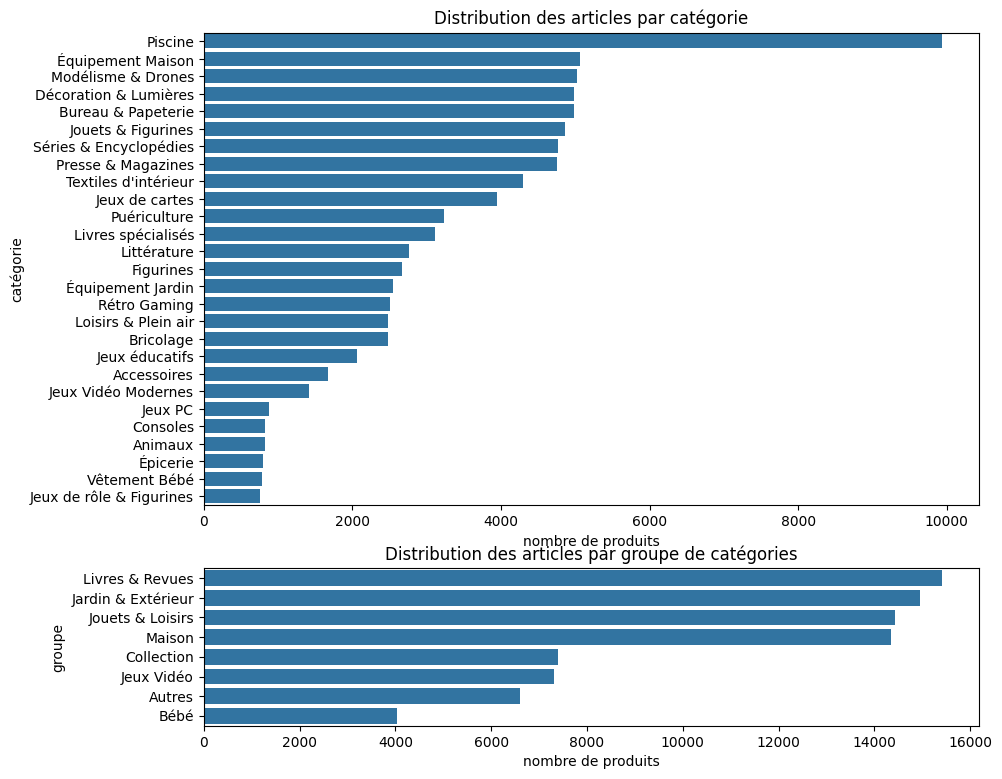

La catégorie la plus représentée est Piscine.
Elle à  13.0  fois plus d'articles que la catégorie Jeux de rôle & Figurines qui est la moins représentée.




In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,9), gridspec_kw={"height_ratios": [3, 1]})

cat_counts = df['category'].value_counts()
sns.barplot(x=cat_counts.values, y=cat_counts.index, ax=ax1)
ax1.set_ylabel('catégorie')
ax1.set_xlabel('nombre de produits')
ax1.set_title('Distribution des articles par catégorie')

group_counts = df['group'].value_counts()
sns.barplot(x=group_counts.values, y=group_counts.index, ax=ax2)
ax2.set_ylabel('groupe')
ax2.set_xlabel('nombre de produits')
ax2.set_title('Distribution des articles par groupe de catégories')

plt.show()

print(
    f"La catégorie la plus représentée est {cat_counts.index[0]}.\nElle à ",
    round(cat_counts.iloc[0]/cat_counts.iloc[-1],1),
    f" fois plus d'articles que la catégorie {cat_counts.index[-1]} qui est la moins représentée.\n\n"
)

La catégorie la plus représentée est Piscine & Accessoires.
Elle à  13.1  fois plus d'articles que la catégorie Jeux de rôle & Figurines qui est la moins représentée.

<div style="background:#fff3cd; padding:12px; border-left:6px solid #ffdd57; border-radius:4px">

Nous remarquons que le jeu de données est déséquilibré. Il sera donc important de stratifier notre jeu lors des splits entraînement / validation pour conserver la distribution dans chacun de ces jeux et éviter d'avoir une classe ignorée car trop peu présente cela pourrait nuire à la performance des modèles sur certaines classes ou fausser l'évaluation car certaines classes y seraient sous-représentées ou sur-représentées. Nous avions vu qu'environ 30 000 descriptions était manquantes. Nous allons maintenant regarder si certaines catégories ont plus de descriptions manquantes que d'autres.</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Observation de la proportion des produits sans description par catégorie</div>

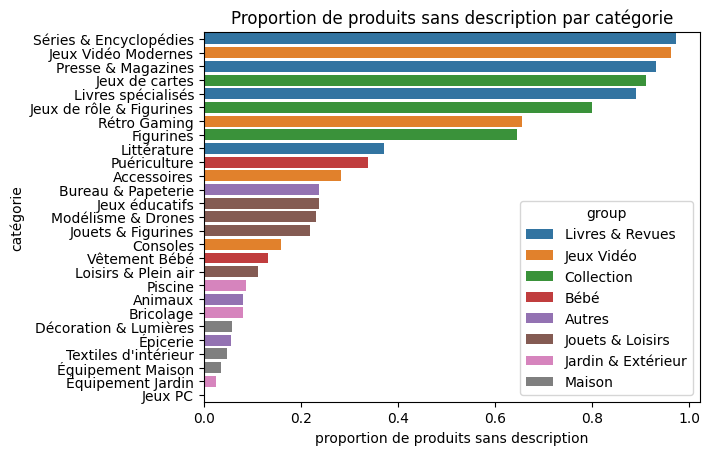

In [ ]:
na_rates = df[df['description'].isna()][['group', 'category']].value_counts() / df[['group', 'category']].value_counts()
na_rates = na_rates.fillna(0).sort_values(ascending=False).reset_index()
sns.barplot(data=na_rates, x='count', y='category', hue='group')
plt.xlabel("proportion de produits sans description")
plt.ylabel("catégorie")
plt.title('Proportion de produits sans description par catégorie');

Ici on remarque que des catégories de produits comme les livres, les revues n'ont pas beaucoup de description, alors que les équipements de la maison en ont souvent. Cela semble cohérent, en général seul le titre d'un livre est nécessaire alors que pour les équipements il est souvent utile de décrire les dimensions par exemple.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">c) Observation de la longueur moyenne des descriptions par catégorie</div>

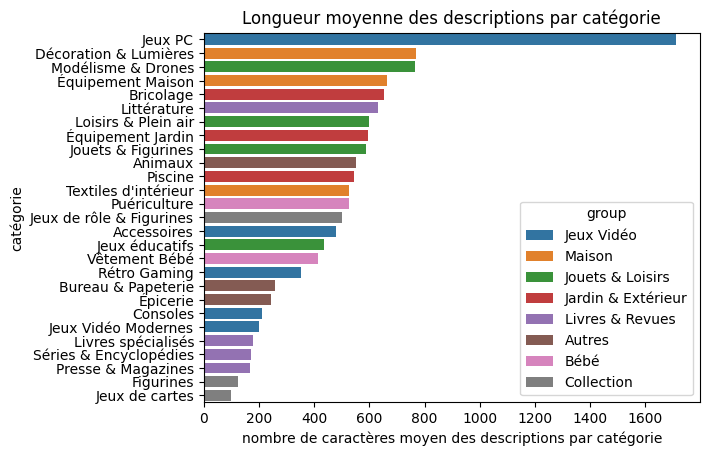

In [ ]:
df["description_cleaned_len"] = df["description_cleaned"].apply(len)
len_means = (df[~df['description'].isna()]
    .groupby(['group', 'category'])["description_cleaned_len"]
    .mean())

len_means = len_means.sort_values(ascending=False).reset_index()

sns.barplot(
    data=len_means,
    x='description_cleaned_len',
    y='category',
    hue='group'
)
plt.xlabel("nombre de caractères moyen des descriptions par catégorie")
plt.ylabel("catégorie")
plt.title('Longueur moyenne des descriptions par catégorie');


En plus d'avoir toujours des descriptions les jeux de PC en téléchargement semblent être très longue avec plus de 2000 caractères en moyenne.

<h3 align="center">
5.3 Traitement des mauvaises classifications
</div>

Le jeu de données est brut et il y a beaucoup de produits classés dans la mauvaise catégorie. Nous allons donc étiqueter les produits qui semblent mal classifiés. Pour cela nous allons utiliser la vectorisation TF-IDF, puis utiliser un modèle de régression logistique entraîné sur les variables issues de la vectorisation et à l'aide de la librairie CleanLearning detecter les produits "suspects". Les données pour lesquels le modèle va prédire une autre classe avec une probabilité élevée seront étiquetées comme suspectes.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">a) Détection des incohérences dans la classification produit</div>




In [ ]:
stop_words = set(stopwords.words('french'))   # on récupère un stopwords adapté au français

# le paramètre ngram_range=(1,2) permet de récupérer unigramme et bigramme
# (par default c'est uniquement les unigrammes, i.e. séquence de un seul mot)
vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))

text = (
    df["designation_cleaned"].fillna("") + " " +
    df["description_cleaned"].fillna("")
).str.lower()
tfidf = vectorizer.fit_transform(text)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
tfidf["category"] = df["category"].values

In [ ]:
from cleanlab.classification import CleanLearning
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

enc = LabelEncoder()                              # il faut encoder sinon ça provoque une erreur; pour k classes les labels doivent être 0,...,k-1
y = enc.fit_transform(tfidf["category"])
clf = LogisticRegression(solver='lbfgs', class_weight="balanced", max_iter=500)   # class_weight="balanced" permet d'équilibrer les classes ???
cleaner = CleanLearning(clf)
cleaner.fit(tfidf.drop("category", axis=1), y)
label_issues = cleaner.get_label_issues()

C:\Users\celin\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(
    f"Il y a {label_issues['is_label_issue'].sum()} produits prédits comme mal classifiés, cela représente",
    f"{round(label_issues['is_label_issue'].sum()/len(df)*100, 2)} % des données."
)

Il y a 11354 produits prédits comme mal classifiés, cela représente 13.44 % des données.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Analyse des produits étiquetés ou non comme problématiques</div>

In [ ]:
df['is_label_issue'] = label_issues.set_index(df.index)['is_label_issue']

# exemple d'un produit mal prédit mais pas tagué. Ici la prédiction semble correcte.
# Même s'il est personnalisé il s'agit d'un article de papeterie et ce n'est pas un livre.

i = 0

print("produit non étiqueté comme problématique.")
print(f"Catégorie de produit : {enc.inverse_transform(label_issues.iloc[i:i+1]['given_label'])[0]}")
print(f"Catégorie de produit prédite : {enc.inverse_transform(label_issues.iloc[i:i+1]['predicted_label'])[0]}")

display_df(df.iloc[i:i+1][['designation', 'description', 'image']])

i = 49

print("produit étiqueté comme problématique.")
print(f"Catégorie de produit : {enc.inverse_transform(label_issues.iloc[i:i+1]['given_label'])[0]}")
print(f"Catégorie de produit prédite : {enc.inverse_transform(label_issues.iloc[i:i+1]['predicted_label'])[0]}")

display_df(df.iloc[i:i+1][['designation', 'description', 'image']])

i = 16

print("produit étiqueté comme problématique.")
print(f"Catégorie de produit : {enc.inverse_transform(label_issues.iloc[i:i+1]['given_label'])[0]}")
print(f"Catégorie de produit prédite : {enc.inverse_transform(label_issues.iloc[i:i+1]['predicted_label'])[0]}")

display_df(df.iloc[i:i+1][['designation', 'description', 'image']])

produit non étiqueté comme problématique.
Catégorie de produit : Livres spécialisés
Catégorie de produit prédite : Livres spécialisés


produit étiqueté comme problématique.
Catégorie de produit : Jouets & Figurines
Catégorie de produit prédite : Décoration & Lumières


produit étiqueté comme problématique.
Catégorie de produit : Séries & Encyclopédies
Catégorie de produit prédite : Presse & Magazines


In [ ]:
# la variable qui va nous permettre de taguer les "presque" doublons
df['near_duplicated'] = False
# nous allons taguer les doublons proches avec des mauvais étiquetage quand ils ont plusieurs valeurs pour is_label_issue
gb = df.groupby(['duplicate_group'])['is_label_issue'].nunique()
groups = gb[gb==2].index
df.loc[df['duplicate_group'].isin(groups) & df['is_label_issue']==True, 'near_duplicated'] = True
# sinon nous taguons les premières entrées pour pouvoir ne garder que la dernière
m = df['near_duplicated'] == False
df.loc[m, 'near_duplicated'] = df[m].duplicated(['duplicate_group'], keep='last')

print(f"{df['near_duplicated'].sum()} lignes ont été taguées comme doublon.")

# nous pouvons maintenant supprimer la variable duplicate_group
df = df.drop('duplicate_group', axis=1)

2719 lignes ont été taguées comme doublon.


Certains articles sont mal tagués mais cela permet d'avoir une base. Regardons maintenant entre quelles catégories les erreurs semblent fréquentes.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">c) Répartition des erreurs par catégories</div>

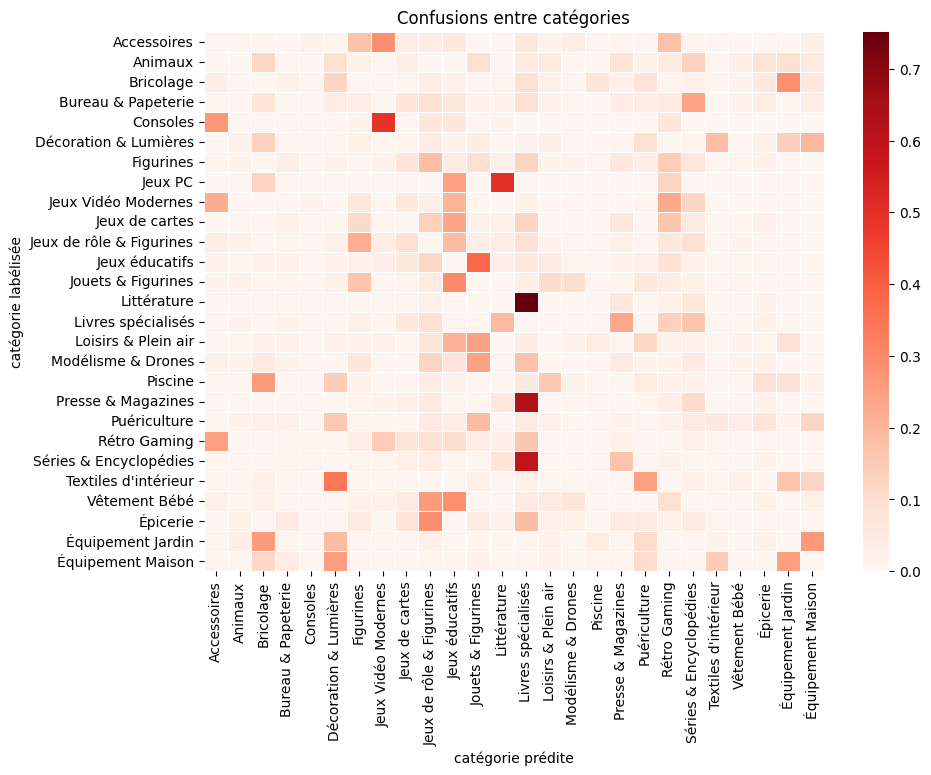

In [ ]:
mask = label_issues["is_label_issue"]

ct = pd.crosstab(
    label_issues[mask]["given_label"],
    label_issues[mask]["predicted_label"],
    normalize="index",
)
ct.columns = enc.inverse_transform(ct.columns)
ct.index = enc.inverse_transform(ct.index)

# mask = np.eye(len(ct), dtype=bool)

plt.figure(figsize=(10, 7))
# sns.heatmap(ct, cmap="Reds", mask=mask, linewidths=.5)
sns.heatmap(ct, cmap="Reds", linewidths=0.5)
plt.ylabel("catégorie labélisée")
plt.xlabel("catégorie prédite")
plt.title("Confusions entre catégories")
plt.show()

On peut remarquer que les catégories Jeux éducatifs et Jouets, figurines semblent se confondre. Sûrement du à une proximité. A priori il y a beaucoup d'erreurs où des livres spécialisés sont labélisés comme des livres de littérature, un peu moins dans le cas inverse. Les erreurs semblent se produire dans des catégories proches.

# VI- Analyse textuelle


Nous allons également faire un nuage de mots par catégories cela permettra de contrôler le nommage de catégories mais également de faire une première analyse sémantique. Pour générer les nuages de mots, nous allons d'abord définir une liste stop_words des mots à exclure de nos nuages de mots, puis faire une vectorisation TF-IDF pour génerer les nuages de mots. "Cela permettra de rendre les nuages de mots plus spécifique à chaque catégorie" (à vérifier si ça a un sens)

<div style="background:#f0f8ff; padding:12px; border-radius:6px ;align=center"><h2 align="center"> 6.1 Nuages de mots par catégorie</h2></div></br>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">a)Génération de nuages de mots par catégorie</div>

In [ ]:
def images_grid(images, nrows=5, ncols=10, cmap=None, titles=None, ordered_by_rows=True, axes_size=(1.5, 1.5)):
    fig, axes = plt.subplots(nrows, ncols, figsize=(axes_size[0]*ncols, axes_size[1]*nrows), squeeze=False)
    axes = axes.flatten()
    if ordered_by_rows:
        axes_order = range(nrows*ncols)
    else:
        axes_order = [i*ncols + j for j in range(ncols) for i in range(nrows)]
    for i in range(nrows*ncols):
        k = axes_order[i]
        if i < len(images):
            axes[k].imshow(images[i], cmap=cmap)
            if titles:
                axes[k].set_title(titles[i], fontsize=8)
        axes[k].set_xticks([])
        axes[k].set_yticks([])
    plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Vérification de la cohérence entre le vocabulaire et le nom de la catégorie</div>

------------------------------ Catégories du groupe Autres ------------------------------


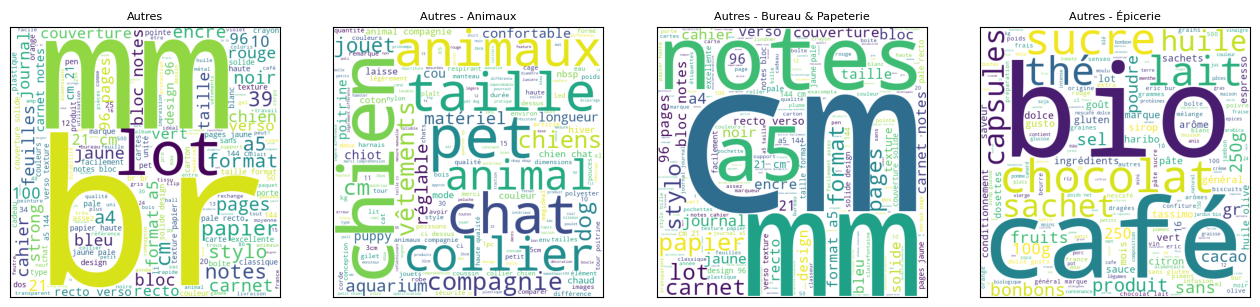

------------------------------ Catégories du groupe Bébé ------------------------------


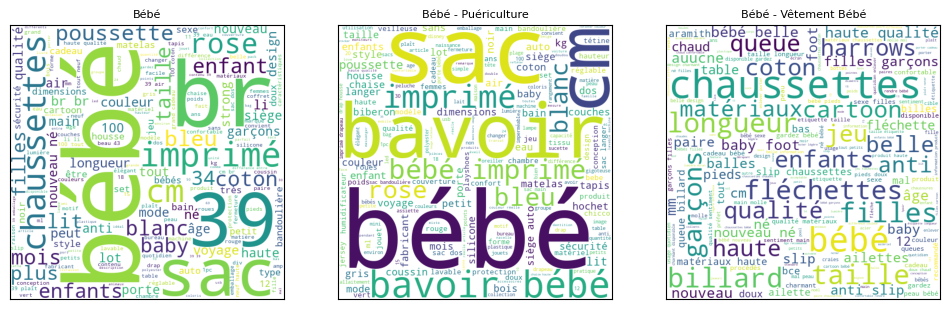

------------------------------ Catégories du groupe Collection ------------------------------


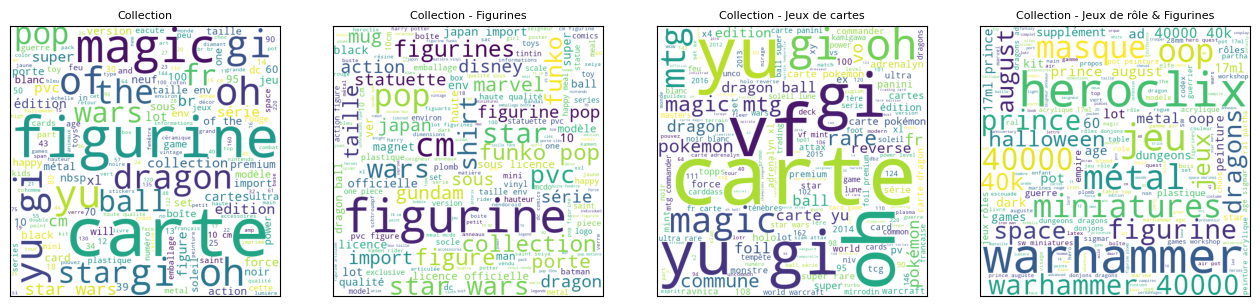

------------------------------ Catégories du groupe Jardin & Extérieur ------------------------------


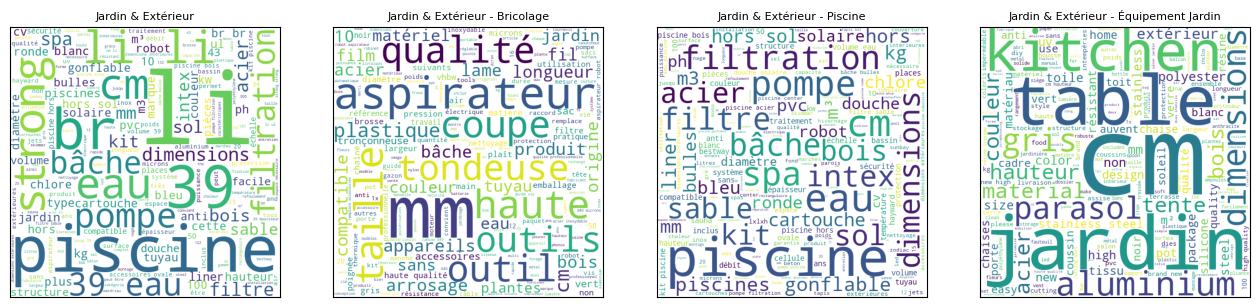

------------------------------ Catégories du groupe Jeux Vidéo ------------------------------


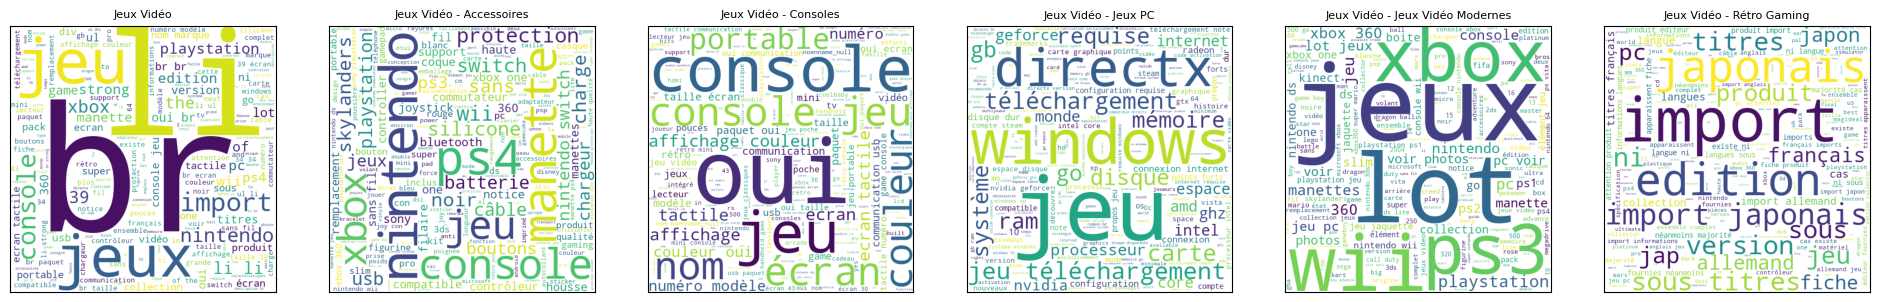

------------------------------ Catégories du groupe Jouets & Loisirs ------------------------------


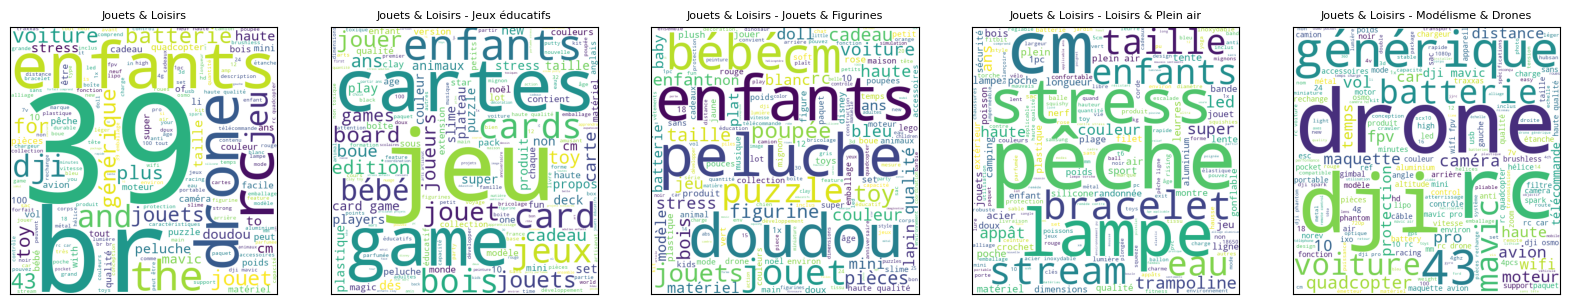

------------------------------ Catégories du groupe Livres & Revues ------------------------------


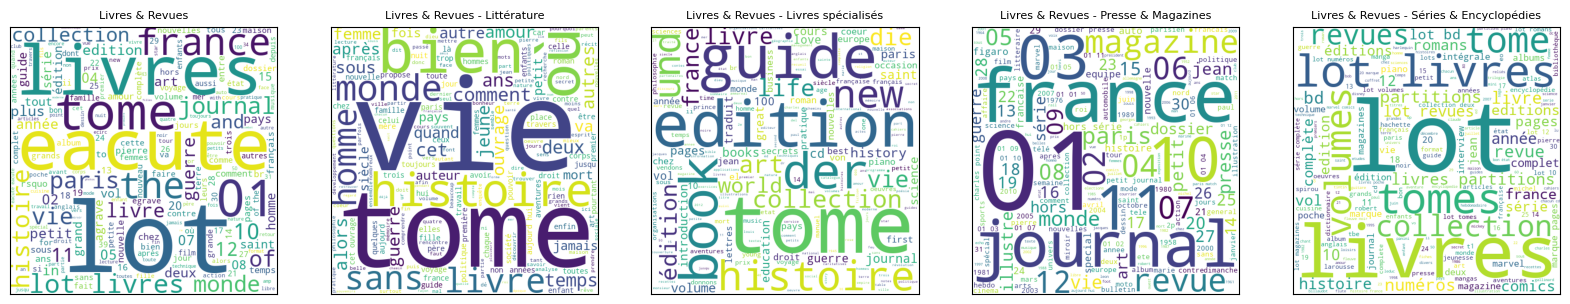

------------------------------ Catégories du groupe Maison ------------------------------


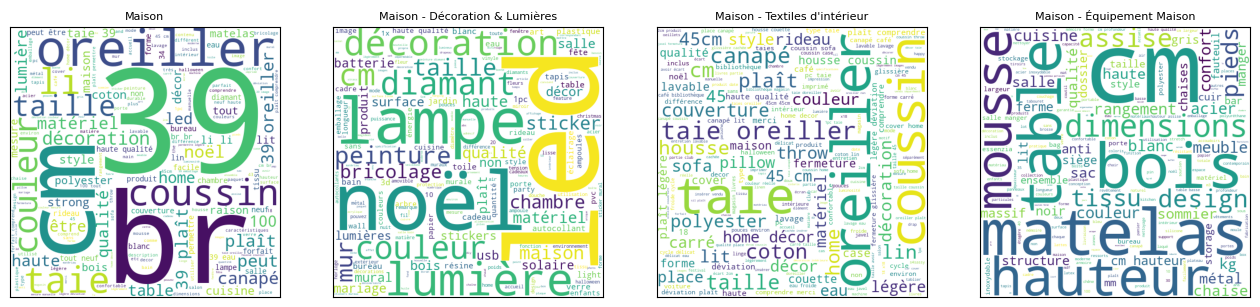

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))

tfidf = vectorizer.fit_transform(df['text'])
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
tfidf["category"] = df["category"].values

tfidf["group"] = df["group"].values

freqs = {}
tfidfgr = {}

for gr in sorted(tfidf["group"].unique()):
    mask = tfidf["group"] == gr
    freqs = {}
    freqs[gr] = tfidf[mask].drop(['category', 'group'], axis=1).mean().sort_values(ascending=False)
    vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))
    tfidfgr[gr] = vectorizer.fit_transform(text[mask])
    tfidfgr[gr] = pd.DataFrame(tfidfgr[gr].toarray(), columns=vectorizer.get_feature_names_out(), index=df[mask].index)
    tfidfgr[gr]["category"] = df[mask]["category"].values
    means_by_cat = tfidfgr[gr].groupby("category").mean()
    for cat in means_by_cat.index:
        freqs[gr+' - '+cat] = means_by_cat.loc[cat].sort_values(ascending=False)
    wc = [WordCloud(width=500, height=500, background_color="white").generate_from_frequencies(f) for f in freqs.values()]
    print('-'*30,'Catégories du groupe', gr, '-'*30)
    images_grid(wc, 1, len(wc), titles=list(freqs), axes_size=(4,4))

Les nuages de mots semblent être en accord avec les catégories et groupes précédemment choisis. Maintenant que nous avons identifié les catégories et avant d'aller plus loin dans l'analyse sémantique, nous allons regarder la distribution des articles à travers les catégories.

<h2 align="center"> 6.2 Analyse de mots clés et de termes génériques</h2></br>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">a) Sélection des termes et expressions à analyser en priorité</div>

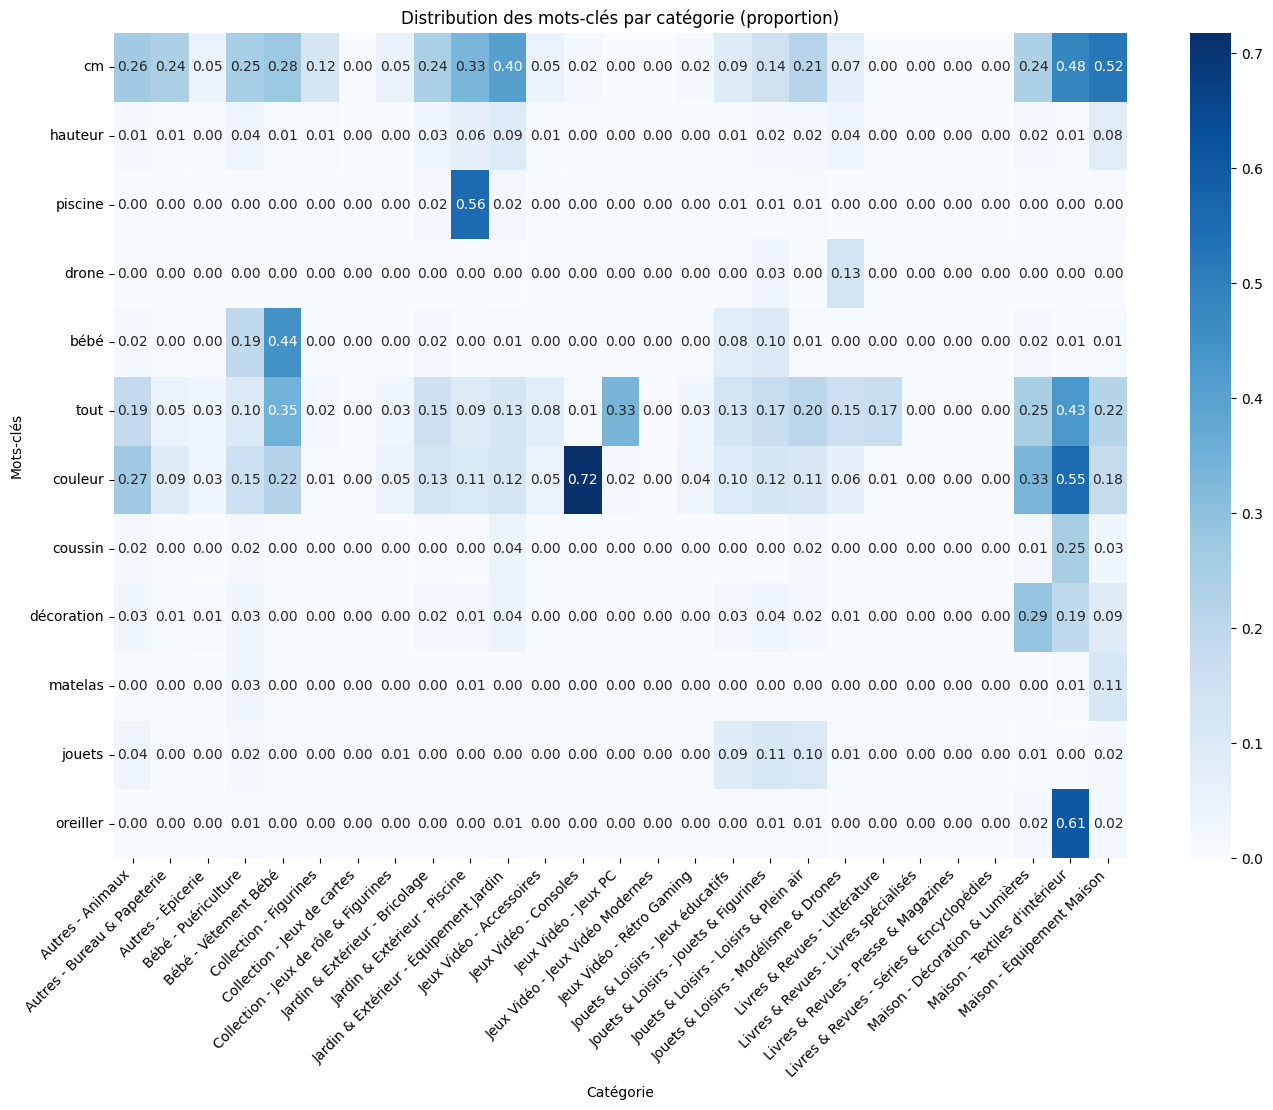

prdtypecode                                        designation  \
productid                                                                    
3804725264           10  Olivia: Personalisiertes Notizbuch / 150 Seite...   
436067568          2280  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
201115110            50  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
50418756           1280  Peluche Donald - Europe - Disneyland 2000 (Mar...   
278535884          2705                               La Guerre Des Tuques   
...                 ...                                                ...   
206719094            40                        The Sims [ Import Anglais ]   
3065095706         2583  Kit piscine acier NEVADA déco pierre Ø 3.50m x...   
440707564          2280  Journal Officiel De La Republique Francaise N°...   
3942400296         1560  Table Basse Bois De Récupération Massif Base B...   
57203227           2522  Gomme De Collection 2 Gommes Pinguin Glace Ver...   

                                                  description  \
productid                                                       
3804725264                                                NaN   
436067568                                                 NaN   
201115110   PILOT STYLE Touch Pen de marque Speedlink est ...   
50418756                                                  NaN   
278535884   Luc a des id&eacute;es de grandeur. Il veut or...   
...                                                       ...   
206719094                                                 NaN   
3065095706  <b>Description complète :</b><br />Kit piscine...   
440707564                                                 NaN   
3942400296  <p>Cette table basse a un design unique et con...   
57203227                                                  NaN   

                                                   image_path  \
productid                                                       
3804725264  images\images\image_train\image_1263597046_pro...   
436067568   images\images\image_train\image_1008141237_pro...   
201115110   images\images\image_train\image_938777978_prod...   
50418756    images\images\image_train\image_457047496_prod...   
278535884   images\images\image_train\image_1077757786_pro...   
...                                                       ...   
206719094   images\images\image_train\image_941495734_prod...   
3065095706  images\images\image_train\image_1188462883_pro...   
440707564   images\images\image_train\image_1009325617_pro...   
3942400296  images\images\image_train\image_1267353403_pro...   
57203227    images\images\image_train\image_684671297_prod...   

                                                        image  \
productid                                                       
3804725264  images/images/image_train/image_1263597046_pro...   
436067568   images/images/image_train/image_1008141237_pro...   
201115110   images/images/image_train/image_938777978_prod...   
50418756    images/images/image_train/image_457047496_prod...   
278535884   images/images/image_train/image_1077757786_pro...   
...                                                       ...   
206719094   images/images/image_train/image_941495734_prod...   
3065095706  images/images/image_train/image_1188462883_pro...   
440707564   images/images/image_train/image_1009325617_pro...   
3942400296  images/images/image_train/image_1267353403_pro...   
57203227    images/images/image_train/image_684671297_prod...   

                                                         text  \
productid                                                       
3804725264  Olivia: Personalisiertes Notizbuch / 150 Seite...   
436067568   Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
201115110   Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
50418756    Peluche Donald - Europe - Disneyland 2000 (Mar...   
278535884   La Guerre Des Tuques Luc a des id&eacute;es de...   
... 

In [ ]:
import re

def plot_keywords_heatmap(df, keywords, text_col="text", by="prdtypecode"):
    category_codes = sorted(df[by].unique())
    result = pd.DataFrame(index=keywords, columns=category_codes, dtype=float)
    for kw in keywords:
        pattern = fr"\b{re.escape(kw)}\b"
        contains_kw = df[text_col].astype(str).str.contains(pattern, na=False)
        freq = contains_kw.groupby(df[by]).mean()
        result.loc[kw, freq.index] = freq.values
    col_labels = [categories.get(code, str(code)) for code in category_codes]
    result_for_plot = result.copy()
    result_for_plot.columns = col_labels
    plt.figure(figsize=(14, len(keywords) * 0.6 + 4))
    sns.heatmap(result_for_plot.astype(float), annot=True, fmt=".2f", cmap="Blues")
    plt.title("Distribution des mots-clés par catégorie (proportion)")
    plt.xlabel("Catégorie")
    plt.ylabel("Mots-clés")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


keywords = [ #"temp", "vidéo", "!",
    "cm", "hauteur",
    "piscine", "drone", "bébé", "tout",
    # "led", "&",
    "couleur",
    "coussin", "décoration", "matelas", "jouets", "oreiller"
]
df['group_cat'] = df['group'] + ' - ' + df['category']
plot_keywords_heatmap(df, keywords, by='group_cat')
df.drop('group_cat', axis=1)

Les jouets semblent être détectés dans les catégories de jouets mais également dans la catégorie des produits pour animaux. matelas est repéré dans la bonne catégorie dédiée (équipement de la maison) mais également dans la catégorie bébé - puériculture pour les matelas bébé, cela semble cohérent.
On peut remarquer qu'il y a des termes qui caractérisent clairement une catégorie par exemple oreiller et coussin pour Textiles d'intérieur, ou piscine pour Piscine & accessoire car ils sont très rarement présents dans les autres catégories.
Des termes comme "tout" semblent également être plus présents dans certaines catégories mais de manière moins marquée.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Calcul du taux d'apparition du mot "tout" par catégorie</div>

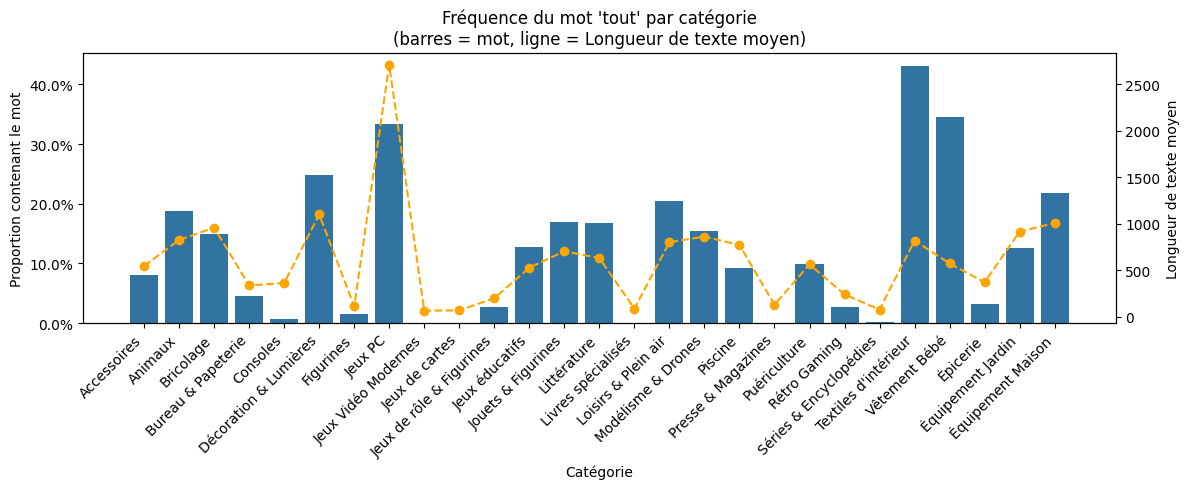

In [ ]:
from matplotlib.ticker import PercentFormatter
import re

text_col = 'text'
keyword = "tout"
pattern = fr"\b{re.escape(keyword)}\b"
contains_word = df[text_col].str.contains(pattern, na=False)
len_text = df[text_col].apply(len)
agg = df.assign(contains_word=contains_word, len_text=len_text).groupby("category").agg(
    contains_ratio=("contains_word", "mean"),
    mean_len_text=("len_text", "mean"),
).reset_index()
agg
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.xticks(rotation=45, ha="right")
sns.barplot(data=agg, x="category", y="contains_ratio", ax=ax1)
ax1.set_ylabel("Proportion contenant le mot")
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(), agg["mean_len_text"], marker="o", linestyle="--", color='orange')
ax2.set_ylabel("Longueur de texte moyen")
ax1.set_xlabel("Catégorie")
plt.title(f"Fréquence du mot '{keyword}' par catégorie\n"
          f"(barres = mot, ligne = Longueur de texte moyen)")

fig.tight_layout()
plt.show()

Le taux d'apparition du mot "tout" par catégorie semble être corrélé à la longueur des descriptions et donc ne pas forcément apporter d'information supplémentaire (à part la forte proportion dans textiles et vêtements bébé & loisirs). On pourrait donc l'ajouter à notre variable stop_words. Nous pouvons effectuer le test de corrélation de Pearson entre la longueur moyenne des textes et le taux d'apparition du mot "tout" par catégorie.

<h2 align="center"> 6.3. Relation entre la longueur des textes et les mots génériques</h2>

In [ ]:
import scipy.stats as stats

pearson_coeff, p_value = stats.pearsonr(agg['contains_ratio'], agg['mean_len_text'])

print(f"P value : {p_value:.4f}")
print(f"coefficient de corrélation : {pearson_coeff:.2f}")

P value : 0.0000
coefficient de corrélation : 0.71


Ici le score est plutôt élevé, ce qui montre qu'il y a une corrélation assez forte entre la longueur moyenne des textes et le taux d'apparition du mot "tout" par catégorie.<br>
On peut également remarquer que certains commentaires sont écrits en langues étrangères. Nous allons les taguer à l'aide de la librairie langdetect.

<h2 align="center"> 6.4. Détection de la langue des descriptions</h2>

In [ ]:
from langdetect import detect, DetectorFactory

# Fixe la graine pour des résultats reproductibles
DetectorFactory.seed = 0

# Fonction de détection
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["detected_lang"] = df["text"].apply(detect_lang)

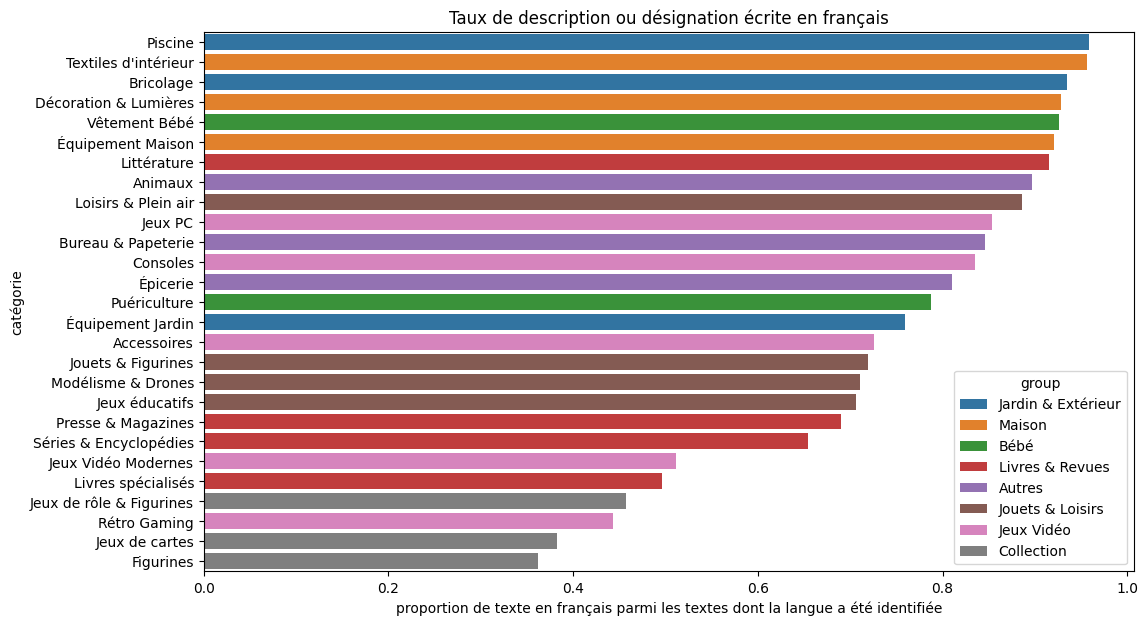

In [ ]:
fr_rate = df[df["detected_lang"] == 'fr'][['group', 'category']].value_counts() / df[df["detected_lang"] != 'unknown'][['group', 'category']].value_counts()
fr_rate = fr_rate.sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,7))
sns.barplot(data=fr_rate, x='count', y='category', hue='group')
plt.title("Taux de description ou désignation écrite en français")
plt.ylabel('catégorie')
plt.xlabel('proportion de texte en français parmi les textes dont la langue a été identifiée');

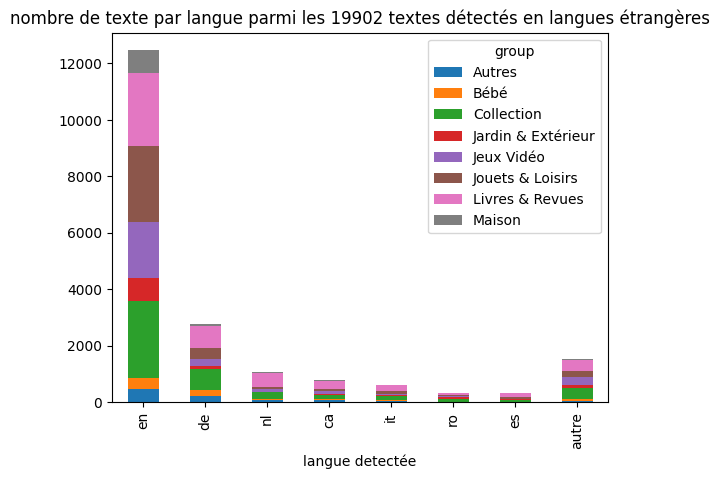

In [ ]:
mask = (df["detected_lang"] != 'fr') & (df["detected_lang"] != 'unknown')
ct = pd.crosstab(df[mask]["detected_lang"], df[mask]["group"])
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]
# pour faire une catégorie "autre" et simplifier le graphique
th = 300
other = ct[ct.sum(axis=1) <= th]
ct = ct.drop(other.index)
ct.loc['autre',:] = other.sum()

ct.plot(kind='bar', stacked=True);
plt.title(f"nombre de texte par langue parmi les {mask.sum()} textes détectés en langues étrangères")
plt.xlabel('langue detectée');

# VII - Features

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 84478 entries, 3804725264 to 57203227
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   prdtypecode              84478 non-null  int64 
 1   designation              84478 non-null  object
 2   description              54731 non-null  object
 3   image_path               84478 non-null  object
 4   image                    84478 non-null  object
 5   text                     84478 non-null  object
 6   text_clean               84478 non-null  object
 7   designation_cleaned      84478 non-null  object
 8   description_cleaned      84478 non-null  object
 9   dup_count                84478 non-null  int64 
 10  is_duplicated_group      84478 non-null  bool  
 11  hashed_image             84478 non-null  object
 12  category                 84478 non-null  object
 13  group                    84478 non-null  object
 14  description_cleaned_len  84478 

Ajout d'une colonne "text_clean" contenant le titre et la description produit.

In [ ]:
df["text_clean"] = (
    df["designation_cleaned"].fillna("") + " " +
    df["description_cleaned"].fillna("")
)

df[["designation_cleaned", "description_cleaned", "text_clean"]].head()


designation_cleaned  \
productid                                                       
3804725264  olivia: personalisiertes notizbuch 150 seiten ...   
436067568   journal arts (le) n° 133 28/09/2001 l'art marc...   
201115110   stylet ergonomique bleu gamepad nintendo wii s...   
50418756    peluche donald europe disneyland 2000 (marionn...   
278535884                                       guerre tuques   

                                          description_cleaned  \
productid                                                       
3804725264                                                      
436067568                                                       
201115110   pilot style touch pen marque speedlink stylet ...   
50418756                                                        
278535884   luc idées grandeur veut organiser jeu guerre b...   

                                                   text_clean  
productid                                                      
3804725264  olivia: personalisiertes notizbuch 150 seiten ...  
436067568   journal arts (le) n° 133 28/09/2001 l'art marc...  
201115110   stylet ergonomique bleu gamepad nintendo wii s...  
50418756    peluche donald europe disneyland 2000 (marionn...  
278535884   guerre tuques luc idées grandeur veut organise...

<div style="background:#f0f8ff; padding:12px; border-radius:6px"><h3 align="center">
7.1. Analyse du nombre de chiffres présent par catégories
</h3>
</div>




Objectif: compter le nombre de chiffres présent en moyenne dans chaque catégorie afin de savoir si les produits sont décrits plutôt avec des phrases ou avec des chiffres (tailles, dimensions, références etc.) et de mesurer el niveau de technicité d'une catégorie.



<div style="background:#f0f8ff; padding:12px; border-radius:6px">a) Observation de la moyenne des chiffres par catégorie</div>

In [ ]:
def count_digits(text):
    """
    Compte le nombre de chiffres (0-9) dans une chaîne de caractères.
    """

    compteur = 0
    for caractere in text:
        if caractere.isdigit():
            compteur = compteur + 1
    return compteur

df["nb_digits_text"] = df["text_clean"].apply(count_digits)

df[["text_clean", "nb_digits_text"]].head(10)


text_clean  nb_digits_text
productid                                                                    
3804725264  olivia: personalisiertes notizbuch 150 seiten ...               4
436067568   journal arts (le) n° 133 28/09/2001 l'art marc...              11
201115110   stylet ergonomique bleu gamepad nintendo wii s...               4
50418756    peluche donald europe disneyland 2000 (marionn...               4
278535884   guerre tuques luc idées grandeur veut organise...               0
5862738     afrique contemporaine n° 212 hiver 2004 dossie...               7
91920807          christof e: bildungsprozessen auf der spur                0
344240059   conquérant sept cahier couverture polypro 240x...              30
4239126071              puzzle scooby-doo poster 2x35 pieces                3
3793572222  tente pliante v3s5-pro pvc blanc 4m50 longueur...              72

Savoir combien il y a de chiffres dans les textes produits permettra de savoir

*   si la feature "nb_digits_text" est pertinente à prendre en compte,
*   quelles sont les catégories qui ont le plus de chiffres.



<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Identification des catégories possedant le plus de chiffres</div>

In [ ]:
target_col = "category"

liste_categories = df[target_col].unique()

resultats = []

for cat in sorted(liste_categories):
    sous_df = df[df[target_col] == cat]
    moyenne = sous_df["nb_digits_text"].mean()
    mediane = sous_df["nb_digits_text"].median()
    minimum = sous_df["nb_digits_text"].min()
    maximum = sous_df["nb_digits_text"].max()

    resultats.append({
        "category": cat,
        "mean_nb_digits": moyenne,
        "median_nb_digits": mediane,
        "min_nb_digits": minimum,
        "max_nb_digits": maximum
    })

stats_digits = pd.DataFrame(resultats)

stats_digits = stats_digits.sort_values("mean_nb_digits", ascending=False)

stats_digits.head(15)


category  mean_nb_digits  median_nb_digits  min_nb_digits  \
7                 Jeux PC       41.490826              31.0              0   
16     Modélisme & Drones       32.658240              19.0              0   
17                Piscine       31.713840              15.0              0   
2               Bricolage       28.938941              18.0              0   
1                 Animaux       23.749696              13.0              0   
25      Équipement Jardin       19.891817              15.0              0   
5   Décoration & Lumières       19.442084              13.0              0   
26      Équipement Maison       18.699783              14.0              0   
22   Textiles d'intérieur       14.821395              12.0              0   
15    Loisirs & Plein air       14.197098               9.0              0   
12     Jouets & Figurines       14.121430               7.0              0   
23          Vêtement Bébé       13.368821               8.0              0   
19           Puériculture       12.793082               6.0              0   
3      Bureau & Papeterie       10.971687               9.0              0   
0             Accessoires       10.640215               3.0              0   

    max_nb_digits  
7             245  
16            800  
17            522  
2            3288  
1             727  
25            182  
5            1181  
26            349  
22            177  
15            167  
12            479  
23            164  
19            193  
3             186  
0             416

Résultat: nous constatons que les moyennes sont très differentes en fonction des catégories (46.5 pour les jeux PC en téléchargement contre 15 pour la catégorie Bureau&Papeterie) donc "nb_digits_text" est bien une feature discriminantes.

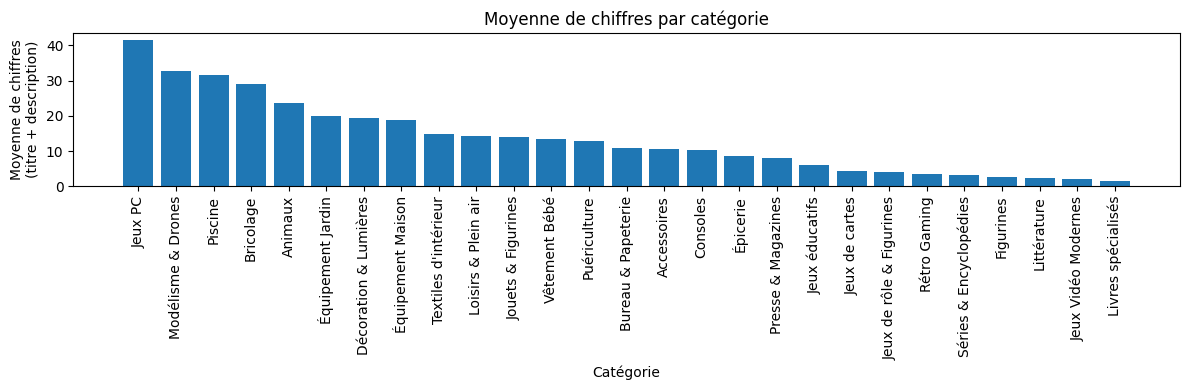

In [ ]:
plt.figure(figsize=(12, 4))

plt.bar(
    stats_digits["category"].astype(str),
    stats_digits["mean_nb_digits"]
)

plt.xlabel("Catégorie")
plt.ylabel("Moyenne de chiffres\n(titre + description)")
plt.title("Moyenne de chiffres par catégorie")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Les catégories contenant le plus de chiffres (Jeux PC en téléchargement, Modélisme&Drone) contiennent généralement des références techniques, produit, tailles de fichiers, version ou encore des dimensions.

Les catégories contenant le moins de chiffres ont des description axées litterature (Livres spécialisés, Littérature).


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h2 align="center">7.2 Détection d'unités par catégorie</h2>




Objectif: identifier, pour chaque description produit, la présence d’unités de mesure (cm, mm, kg, L, ml, W, V, Go, etc.), puis analyser leur distribution par catégorie.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">a) Dictionnaire des unités de mesure présentes dans les textes</div>

In [ ]:

unit_patterns = {
    # Dimensions
    "cm":   r"\b\d+\s*(cm|centimetre?s?|centimètre?s?)\b",
    "mm":   r"\b\d+\s*(mm|millimetre?s?|millimètre?s?)\b",
    "m":    r"\b\d+\s*(m|metre?s?|mètre?s?)\b",

    # Poids
    "kg":   r"\b\d+\s*(kg|kilo|kilogramme?s?)\b",
    "g":    r"\b\d+\s*(g|gramme?s?)\b",

    # Volume
    "ml":   r"\b\d+\s*(ml|millilitres?|millilitre?)\b",
    "l":    r"\b\d+\s*(l|litres?|litre?)\b",
    "cl":   r"\b\d+\s*cl\b",  # ex : 50cl

    # Dimensions éventuellement suivies d'une unité
    "x_dim": r"\b\d+\s*(x|×)\s*\d+(\s*(cm|mm|m))?\b",

    # Âge
    "age_ans":  r"\b\d+\s*ans\b",
    "age_mois": r"\b\d+\s*mois\b",

    # Pouces (écrans, certains produits tech)
    "inch": r'\b\d+\s*(\"|pouces?|po)\b',
}

compiled_patterns = []
for pattern in unit_patterns.values():
    regex_obj = re.compile(pattern, flags=re.IGNORECASE)
    compiled_patterns.append(regex_obj)


In [ ]:
def detect_any_unit(text, list_of_regex):
    """
    Retourne 1 si le texte contient au moins une unité (parmi la liste de regex),
    sinon 0.
    """
    text = str(text)

    for regex_pattern in list_of_regex:
        if regex_pattern.search(text):
            return 1
    return 0



In [ ]:
df["has_any_unit"] = df["text_clean"].apply(
    lambda txt: detect_any_unit(txt, compiled_patterns)
)

df[["text_clean", "has_any_unit"]].head(10)


text_clean  has_any_unit
productid                                                                  
3804725264  olivia: personalisiertes notizbuch 150 seiten ...             0
436067568   journal arts (le) n° 133 28/09/2001 l'art marc...             1
201115110   stylet ergonomique bleu gamepad nintendo wii s...             0
50418756    peluche donald europe disneyland 2000 (marionn...             0
278535884   guerre tuques luc idées grandeur veut organise...             0
5862738     afrique contemporaine n° 212 hiver 2004 dossie...             0
91920807          christof e: bildungsprozessen auf der spur              0
344240059   conquérant sept cahier couverture polypro 240x...             1
4239126071              puzzle scooby-doo poster 2x35 pieces              1
3793572222  tente pliante v3s5-pro pvc blanc 4m50 longueur...             1

<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Fréquence des unités par catégorie produit</div>

Ici, on cherche à savoir dans chaque catégorie, quel pourcentage de produits contient au moins une unité.

In [ ]:
target_col = "category"

liste_categories = sorted(df[target_col].unique())

resultats = []

for cat in liste_categories:
    sous_df = df[df[target_col] == cat]

    nb_produits = len(sous_df)
    if nb_produits == 0:
        continue

    taux_unites = sous_df["has_any_unit"].mean()
    pourcentage = taux_unites * 100

    resultats.append({
        "categorie": cat,
        "nb_products": nb_produits,
        "pct_products_with_unit": pourcentage
    })

stats_units_any = pd.DataFrame(resultats)

# Affichage des catégories par pourcentage décroissant
stats_units_any = stats_units_any.sort_values(
    "pct_products_with_unit",
    ascending=False
)

stats_units_any.head(20)


categorie  nb_products  pct_products_with_unit
22      Textiles d'intérieur         4300               89.162791
26         Équipement Maison         5063               80.051353
1                    Animaux          823               79.343864
5      Décoration & Lumières         4990               78.537074
25         Équipement Jardin         2542               75.216365
23             Vêtement Bébé          789               71.609632
2                  Bricolage         2473               68.580671
17                   Piscine         9935               65.485657
3         Bureau & Papeterie         4980               64.698795
15       Loisirs & Plein air         2481               62.071745
24                  Épicerie          802               58.229426
19              Puériculture         3238               50.555899
12        Jouets & Figurines         4867               48.736388
16        Modélisme & Drones         5024               48.009554
4                   Consoles          829               38.480097
11            Jeux éducatifs         2069               31.077815
6                  Figurines         2671               25.645826
0                Accessoires         1676               24.761337
7                    Jeux PC          872               18.922018
10  Jeux de rôle & Figurines          763               13.761468

Nous constatons que la catégorie "Textiles d'intérieur" contient quasi systématiquement des mesures(90%) contrairement à d'autres comme Jeux de rôle& Figurines(15%). La feature "has_any_unit" est donc très caractéristique.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">c) Affichage de toutes les catégories en fonction du nombre d'unités quelles possèdent</div>

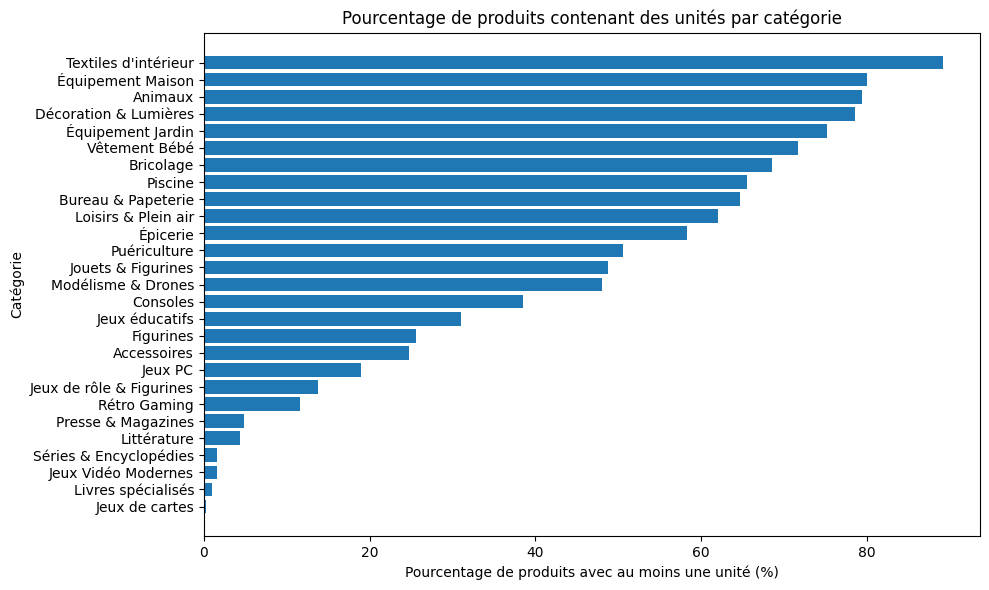

In [ ]:
plt.figure(figsize=(10, 6))


plot_df = stats_units_any.sort_values("pct_products_with_unit", ascending=True)

plt.barh(
    plot_df["categorie"].astype(str),
    plot_df["pct_products_with_unit"]
)

plt.xlabel("Pourcentage de produits avec au moins une unité (%)")
plt.ylabel("Catégorie")
plt.title("Pourcentage de produits contenant des unités par catégorie")
plt.tight_layout()
plt.show()


Résultat: nous constatons que les catégories se distinguent bien:

*   Vêtement Bébé & Loisirs (73 %), cohérent avec les âges (ans, mois) et parfois dimensions.
*   Bricolage & Outillage (72 %),  mm, cm, W, V, etc., très cohérent également.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">d) Combinaison du nombre de chiffres et d'unités par catégorie</div>





In [ ]:
target_col = "category"

liste_categories = sorted(df[target_col].unique())

resultats_cat = []

for cat in liste_categories:
    sous_df = df[df[target_col] == cat]

    nb_produits = len(sous_df)
    if nb_produits == 0:
        continue

    mean_nb_digits = sous_df["nb_digits_text"].mean()


    taux_unites = sous_df["has_any_unit"].mean()
    pct_with_unit = taux_unites * 100

    resultats_cat.append({
        "category": cat,
        "nb_products": nb_produits,
        "mean_nb_digits": mean_nb_digits,
        "pct_with_unit": pct_with_unit
    })

stats_cat = pd.DataFrame(resultats_cat)

stats_cat.head()


category  nb_products  mean_nb_digits  pct_with_unit
0         Accessoires         1676       10.640215      24.761337
1             Animaux          823       23.749696      79.343864
2           Bricolage         2473       28.938941      68.580671
3  Bureau & Papeterie         4980       10.971687      64.698795
4            Consoles          829       10.293124      38.480097

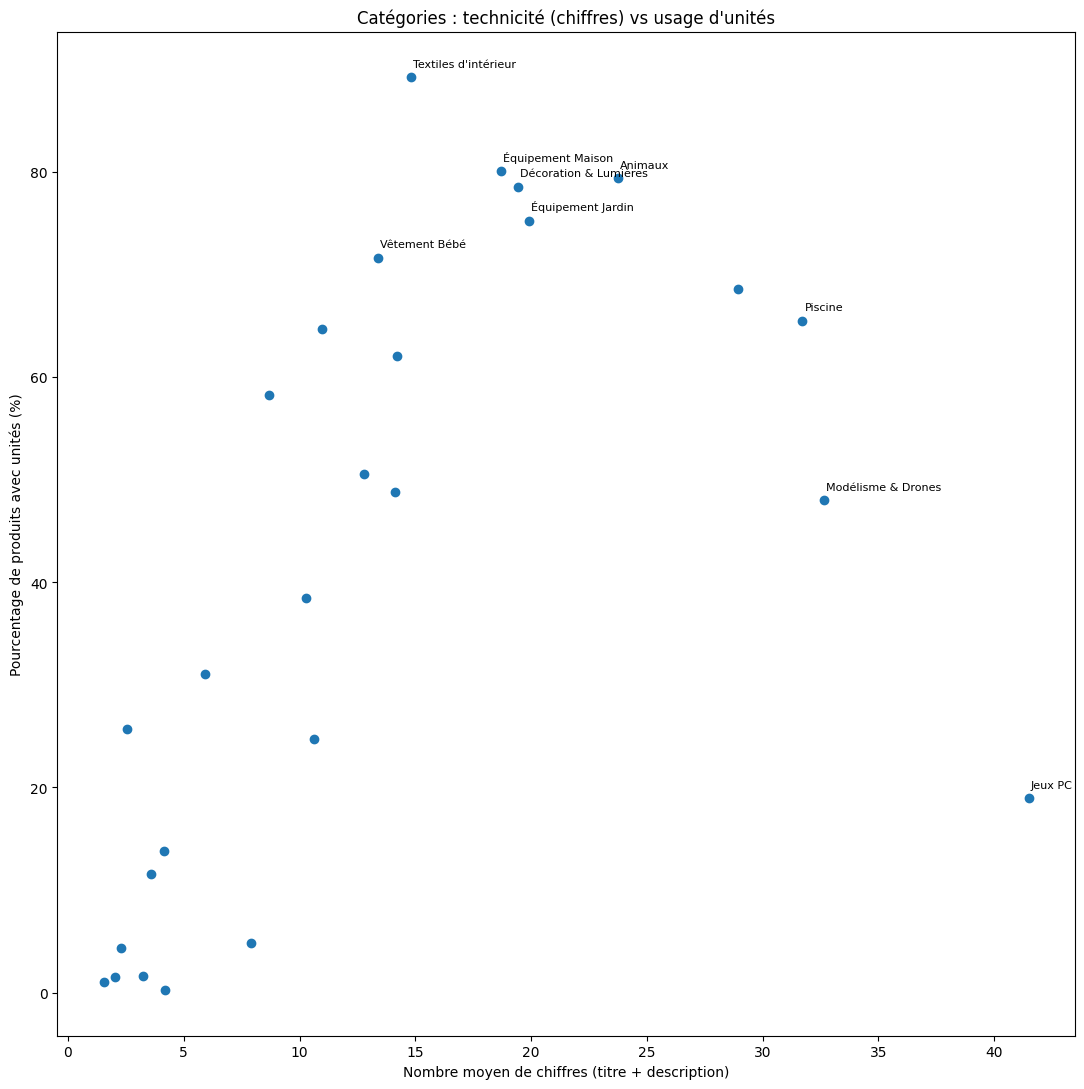

In [ ]:
plt.figure(figsize=(11, 11))

plt.scatter(
    stats_cat["mean_nb_digits"],
    stats_cat["pct_with_unit"]
)

plt.xlabel("Nombre moyen de chiffres (titre + description)")
plt.ylabel("Pourcentage de produits avec unités (%)")
plt.title("Catégories : technicité (chiffres) vs usage d'unités")

seuil_pct = 70
seuil_digits = stats_cat["mean_nb_digits"].quantile(0.9)

for _, row in stats_cat.iterrows():
    x = row["mean_nb_digits"]
    y = row["pct_with_unit"]
    nom_cat = str(row["category"])

    if (y > seuil_pct) or (x > seuil_digits):
        plt.text(x + 0.1, y + 1, nom_cat, fontsize=8)

plt.tight_layout()
plt.show()



Plus une catégorie est technique plus elle est située vers le haut à droite. Les catégories les moins techniques sont situés vers le bas à gauche.

Les jeux PC en téléchargement ont beaucoup de chiffres et peu d'unités, cela peut correspondre à des versions, numéros de produits.

Les produits techniques comportant des souvent dimensions (piscines&accessoires, bricolage&outillage) ont des descriptions qui conrrespondent à des spécifications produits. Leur localisation correspondent bien à leur typologie.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h3 align="center">
7.4 Présence de numéro dans la description produit
</h3>
</div>

Objectif: détecter les mentions de type "n°4838" dans les descriptions produit afin d'identifier les catégories où la notion de numéro est fréquente.

C:\Users\celin\AppData\Local\Temp\ipykernel_27148\858791899.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["contains_numerotation"] = df["text_clean"].str.contains(r"n° ?([0-9])+")


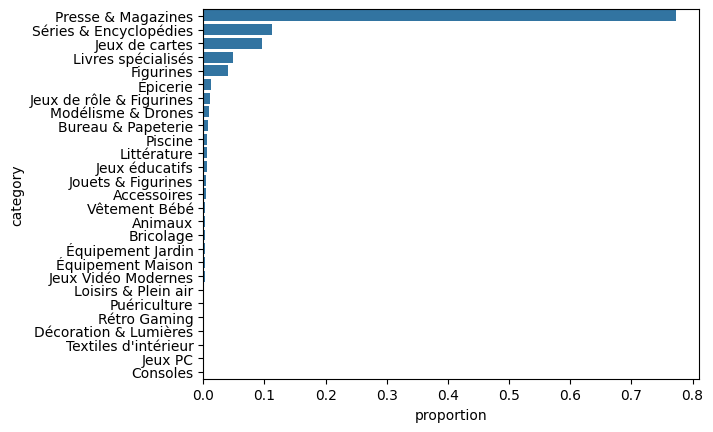

In [ ]:
df["contains_numerotation"] = df["text_clean"].str.contains(r"n° ?([0-9])+")
num_counts = (df[df["contains_numerotation"]]["category"].value_counts() / df["category"].value_counts()).fillna(0).sort_values(ascending=False)
sns.barplot(num_counts, orient='h')
plt.xlabel('proportion');

Nous constatons que certains produits possèdent des numéros de parution, cela concerne plus de 80% de la catégorie "Presse&Magazine".

Résultat: la feature contains_numerotation est très spécifique des produits de type presse et est donc discriminant donc pertinent à prendre en compte.

En conclusion, les features dérivées des chiffres, des unités et des
mentions d’âge / taille / pointure apportent une distinction forte, elles permettent de mieux séparer les familles de produits et de comprendre ce que le modèle pourra exploiter au-delà de TF-IDF.

<div style="background:#f0f8ff; padding:12px; border-radius:6px"><h2 align="center"> 7.5 Tester l'impact de variables indicatrices sur la présence ou non de certains mots</h2></div>

Avec cette feature, nous  cherchons à mesurer l’impact de variables indicatrices simples basées sur la présence ou l’absence de certains mots clés dans les descriptions produits. L’objectif est de vérifier si ces marqueurs textuels apportent une information complémentaire. Nous examinerons ainsi dans quelle mesure ces features peuvent aider à mieux différencier certaines catégories de produits.

In [ ]:
df[df.detected_lang == "fr"]
df= df[df.detected_lang == "fr"]

<div style="background:#f0f8ff; padding:12px; border-radius:6px">a) Création des variables de la feature</div>


Exploration initiale : comprendre les catégories grâce aux nuages de mots L’objectif de cette section est de transformer notre texte brut en variables exploitables pour un futur modèle de classification. Pour cela, nous avons commencé par une exploration visuelle des nuages de mots crées précedement Cette étape nous permettait de repérer intuitivement :

les mots les plus présents,
les expressions qui reviennent naturellement,
les termes potentiellement discriminants.
C’est à partir de ces nuages que nous avons identifié nos premiers mots suspects: par exemple, "collier" et "chien" apparaissaient fortement dans la catégorie Animaux, tandis que "coussin" ou "taie" dominaient dans Textiles d’intérieur.

À partir de cette analyse, nous construisons ici un dictionnaire de mots-clés par catégorie. Ces listes serviront de base à la création de notre première feature.

In [ ]:
import pandas as pd
import numpy as np

# 1. Definir les mots clés par catégorie

keyword_dict = {
    "Animaux": [ "chien", "chat", "animal", "compagnie", "collier"],
    "Bureau & Papeterie": ["verso", "cahier", "encre", "papier", "recto", "a5"],
    "Épicerie": ["epices", "arôme", "chocolat", "sucre", "sachet", "capsule"],
    "Puériculture": ["langer", "bavoir", "assiette", "siege", "tétine", "poussette"],
    "Vêtement Bébé & Loisirs": ["bébé", "chaussettes", "paire", "longueur", "filles","garçons"],
    "Figurines": ["figurine", "gundam", "statuette", "officiel", "marvel", "funko"],
    "Jeux de cartes":["mtg", "oh", "rare", "vf", "carte", "magic"],
    "Jeux de rôle & Figurines": ["halloween", "figurine", "warhammer", "prince", "masque"],
    "Bricolage & Outillage": ["arrosage", "tondeuse", "aspirateur", "appareils", "outil", "coupe", "bâche"],
    "Décoration & Équipement Jardin": ["bois", "jardin", "résistant", "tente", "parasol", "aluminium"],
    "Piscine & Accessoires": ["piscine", "filtration", "pompe", "dimensions","eau", "ronde"],
    "Accessoires & Périphériques":["nintendo", "manette", "protection", "ps4", "silicone", "câble"],
    "Consoles": ["console", "oui", "jeu", "écran", "portable", "marque", "jeux"],
    "Jeux PC en Téléchargement":["windows", "jeu", "directx", "plus", "téléchargement", "disque", "édition"],
    "Jeux Vidéo Modernes": ["duty","jeux", "manettes", "ps3", "xbox", "kinect"],
    "Rétro Gaming": ["japonais", "import", "langue", "titres", "sous", "français"],
    "Jeux éducatifs": ["joue", "cartes", "enfants", "éducatif", "bois", "jouer"],
    "Jouets & Figurines": ["doudou", "enfants", "cadeau", "peluche", "jouet", "puzzle"],
    "Loisirs & Plein air": ["camping", "pêche", "stress", "stream", "bracelet", "trampoline"],
    "Modélisme & Drones": ["drone", "générique", "dji", "avion", "batterie", "cámera", "one"],
    "Littérature": ["monde", "ouvrage", "siècle", "roman", "livre", "histoire", "tome"],
    "Livres spécialisés": ["guide", "édition", "histoire", "art", "collection"],
    "Presse & Magazines": ["journal", "france", "illustre", "magazine", "presse", "revue"],
    "Séries & Encyclopédies":[ "lot", "livres", "tomes", "volumes", "tome", "revues"],
    "Décoration & Lumières": ["led", "noël", "lumière", "lampe", "décoration", "couleur"],
    "Textiles d'intérieur": ["oreiller", "taie", "coussin", "couverture", "canapé", "cotton"],
     "Équipement Maison":["matelas", "assise", "bois", "table", "hauteur", "mousse"]

}

# Construire un texte global
df["text"] = (df["designation_cleaned"].fillna("") + " " +df["description_cleaned"].fillna("")).str.lower()

# Génération des colonnes de comptage

data = {}

for cat, mots in keyword_dict.items():
    pattern = '|'.join(mots)  # expression régulière
    data[cat + "_keywords"] = df["text"].str.count(pattern)

# Convertir en DataFrame final
new_X = pd.DataFrame(data)
new_X

Animaux_keywords  Bureau & Papeterie_keywords  Épicerie_keywords  \
productid                                                                      
436067568                  0                            0                  0   
201115110                  0                            0                  0   
278535884                  0                            0                  0   
5862738                    0                            0                  0   
344240059                  0                            3                  0   
...                      ...                          ...                ...   
2699568414                 3                            0                  0   
3065095706                 0                            0                  0   
440707564                  0                            0                  0   
3942400296                 0                            0                  0   
57203227                   0                            0                  0   

            Puériculture_keywords  Vêtement Bébé & Loisirs_keywords  \
productid                                                             
436067568                       0                                 0   
201115110                       0                                 0   
278535884                       0                                 0   
5862738                         0                                 0   
344240059                       0                                 0   
...                           ...                               ...   
2699568414                      0                                 0   
3065095706                      0                                 0   
440707564                       0                                 0   
3942400296                      0                                 0   
57203227                        0                                 0   

            Figurines_keywords  Jeux de cartes_keywords  \
productid                                                 
436067568                    0                        0   
201115110                    0                        0   
278535884                    0                        0   
5862738                      0                        0   
344240059                    0                        0   
...                        ...                      ...   
2699568414                   0                        0   
3065095706                   0                        0   
440707564                    3                        0   
3942400296                   0                        0   
57203227                     0                        0   

            Jeux de rôle & Figurines_keywords  Bricolage & Outillage_keywords  \
productid                                                                       
436067568                                   0                               0   
201115110                                   0                               0   
278535884                                   0                               0   
5862738                                     0                               0   
344240059                                   0                               0   
...                                       ...                             ...   
2699568414                                  0                               0   
3065095706                                  0                               0   
440707564                                   0                               0   
3942400296                                  0                               0   
57203227                                    0                               0   

            Décoration & Équipement Jardin_keywords  ...  \
productid                                            ...   
436067568                                         0  ...   
201115110                                    


Après avoir construit notre dictionnaire final de mots-clés, nous voulons vérifier comment ces mots se distribuent dans l’ensemble des produits. Pour cela, nous créons une matrice binaire où chaque colonne correspond à une catégorie et chaque valeur indique le nombre d’occurrences des mots-clés associés à cette catégorie dans le texte d’un produit.

Cela revient à traduire le texte en signaux simples :

0 → aucun mot-clé de la catégorie n’apparaît
0 → le produit contient au moins un mot-clé, voire plusieurs

Cette table est extrêmement utile pour plusieurs raisons : Visualiser la couverture des mots-clés, détecter les mots ambigus ou bruités, analyser les produits ambigus, préparer les features pour le modèle

In [ ]:
# keywords / catégorie
total_keywords_per_category = new_X.sum().sort_values(ascending = False)
total_keywords_per_category



Piscine & Accessoires_keywords             121626
Décoration & Lumières_keywords              68781
Équipement Maison_keywords                  52556
Livres spécialisés_keywords                 44956
Textiles d'intérieur_keywords               43436
Consoles_keywords                           41666
Jeux éducatifs_keywords                     40476
Modélisme & Drones_keywords                 34603
Jouets & Figurines_keywords                 33801
Décoration & Équipement Jardin_keywords     28729
Jeux PC en Téléchargement_keywords          24230
Vêtement Bébé & Loisirs_keywords            20932
Accessoires & Périphériques_keywords        17107
Bricolage & Outillage_keywords              16777
Séries & Encyclopédies_keywords             10979
Rétro Gaming_keywords                       10803
Littérature_keywords                         9906
Bureau & Papeterie_keywords                  9521
Loisirs & Plein air_keywords                 9305
Jeux de cartes_keywords                      8641


Validation des mots repérés dans les nuages de mots

Une fois quelques mots-clés potentiels repérés, nous avons voulu vérifier s’ils étaient réellement représentatifs de la catégorie officielle. Pour cela, nous utilisons le texte combiné (désignation + description) et nous calculons, pour un mot donné, la proportion de produits dans chaque catégorie qui le contiennent.

L’objectif est simple : si un mot provient bien de la bonne catégorie, alors sa fréquence doit être nettement plus élevée dans cette catégorie que dans les autres.

Ce test visuel (barplot) nous permet de analyser la fréquence d’un mot dans chaque catégorie. Si les mots sont:

=> réellement discriminants (on les garde),
=> trop génériques (on les élimine).

S’il apparaît dans plusieurs catégories → il peut être ambigu. Dans ce cas : nous observons le pourcentage total de produits contenant ce mot, nous comparons sa distribution entre catégories, et nous décidons si le mot doit être reclassé, conservé ou supprimé.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">b) Analyse de la distribution par catégorie</div>

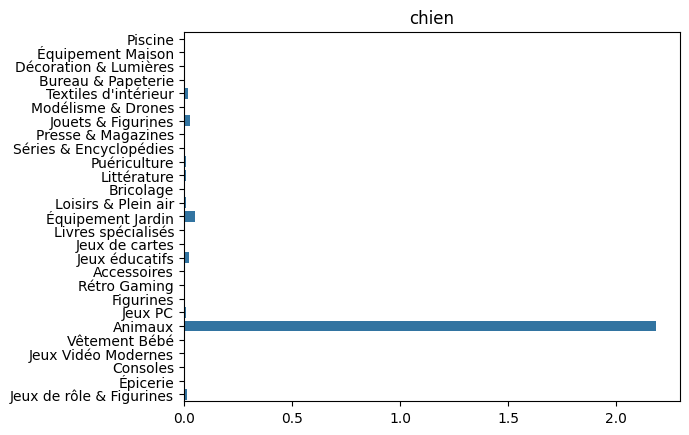

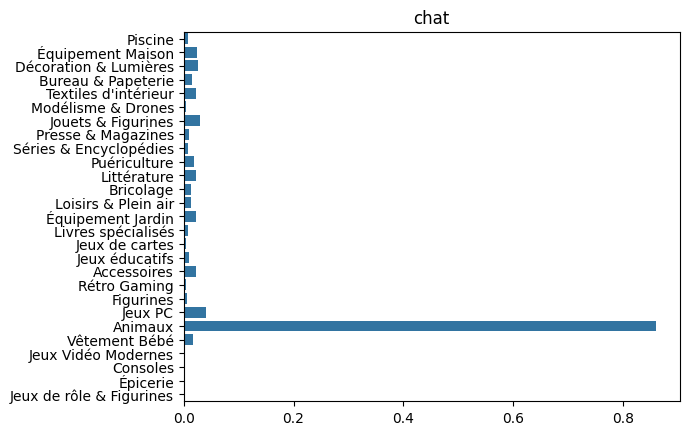

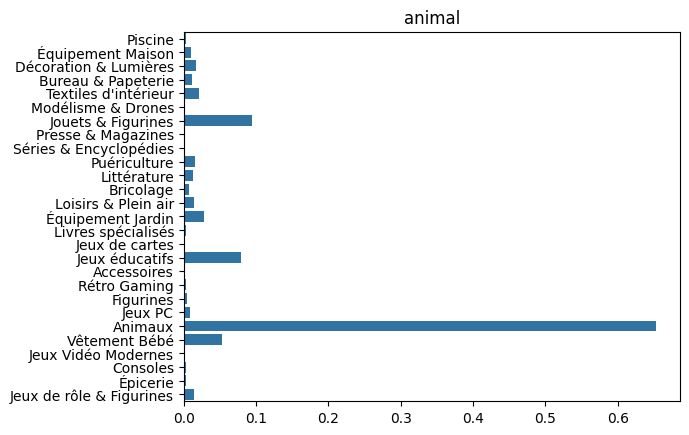

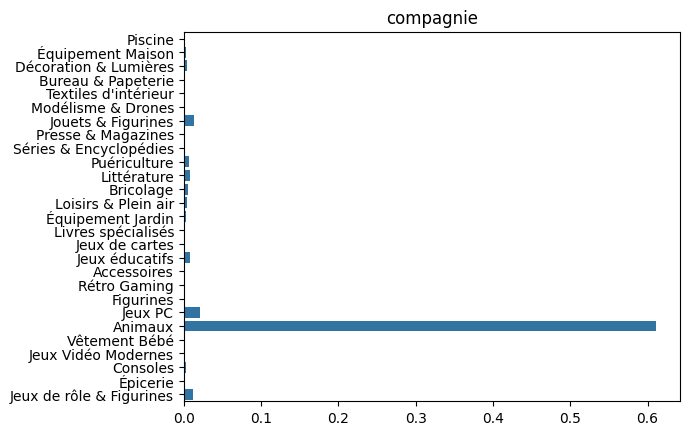

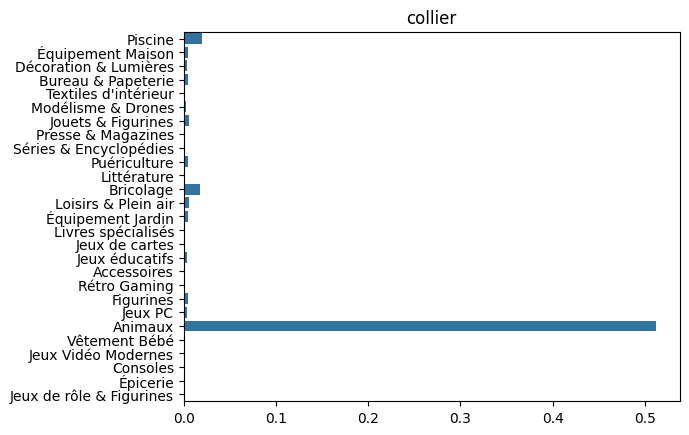

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
y = df['category']
for keyword in ["chien", "chat", "animal", "compagnie", "collier"]:
    count_kw = df["text"].str.lower().str.count(keyword)
    cat_counts = y.value_counts()
    freq = {}
    for cat, count in cat_counts.items():
        freq[cat] = count_kw[y==cat].sum() / count
    sns.barplot(y=freq.keys(), x=freq.values(), orient='h')
    plt.title(keyword)
    plt.show()




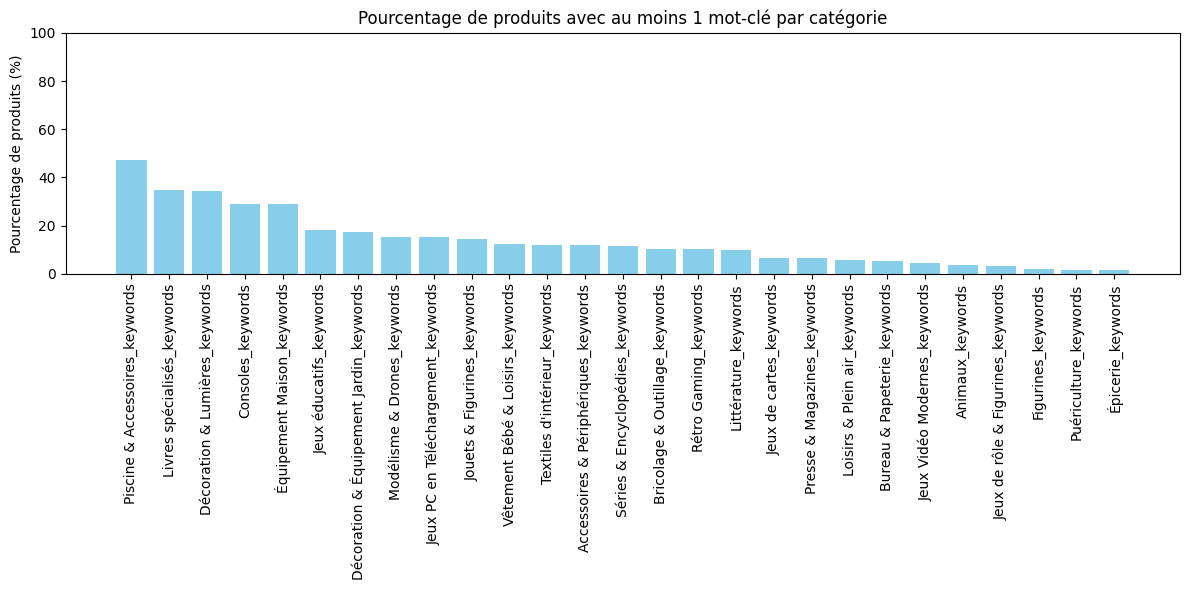

In [ ]:


# Créer un DataFrame booléen : True si au moins 1 mot-clé
has_keyword = new_X >= 1

# Calculer le pourcentage de produits avec ≥1 mot-clé par catégorie
percentage_per_category = has_keyword.sum() / len(new_X) * 100

# Trier de manière décroissante
percentage_per_category = percentage_per_category.sort_values(ascending=False)

# Graphique en barres
plt.figure(figsize=(12, 6))
plt.bar(percentage_per_category.index, percentage_per_category.values, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Pourcentage de produits (%)")
plt.title("Pourcentage de produits avec au moins 1 mot-clé par catégorie")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()




Grâce aux graphiques de représentativité, nous identifions :

les mots bien alignés avec leur catégorie
les mots trop diffus
les catégories sous-représentées
Ce processus itératif améliore la qualité des features et prépare un terrain solide pour l’entraînement du modèle. Nous construisons progressivement une base de mots-clés fiable, directement justifiée par les données.

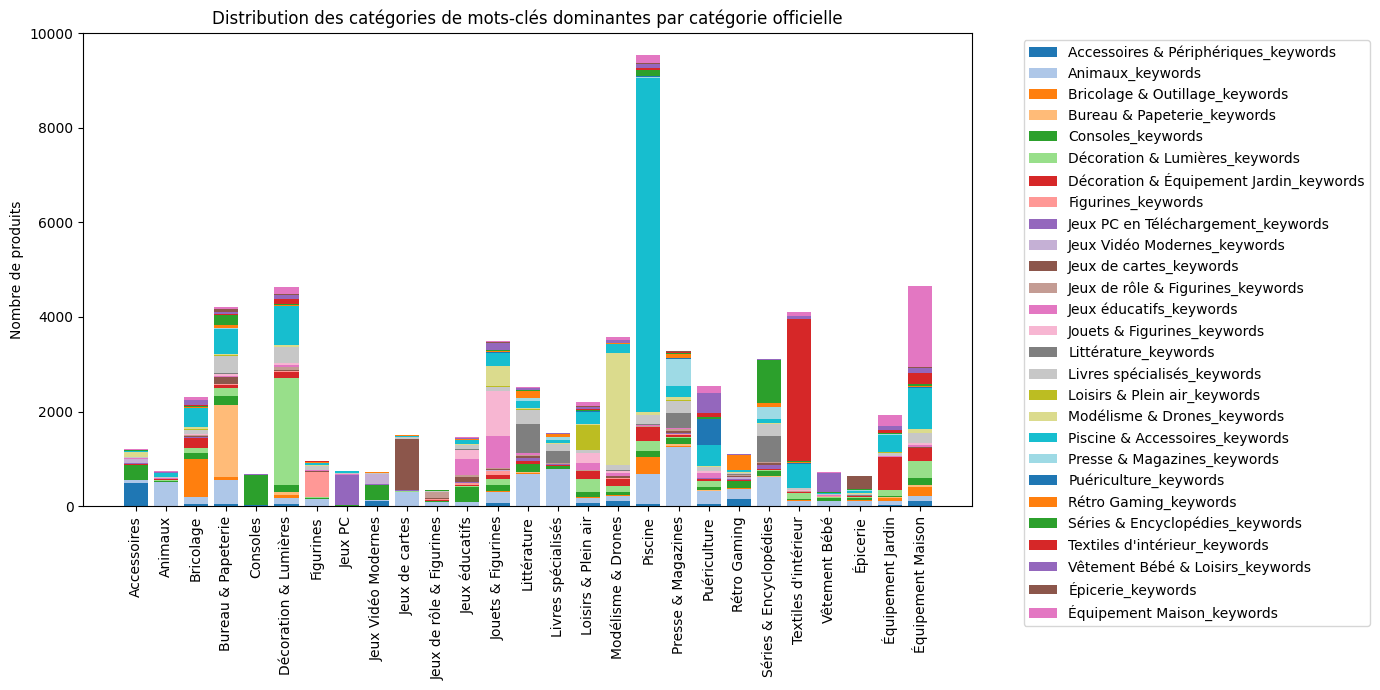

In [ ]:

# Catégorie dominante de mots-clés par produit
categorie_motcle_dominante = new_X.idxmax(axis=1)

# Tableau croisé : lignes = catégorie officielle, colonnes = catégorie dominante de mots-clés
distribution = pd.crosstab(df['category'], categorie_motcle_dominante)

# --- Palette de 27 couleurs bien distinctes ---
from itertools import chain
import matplotlib.pyplot as plt

# Combinaison de palettes très contrastées
palette1 = plt.cm.tab20.colors          # 20 couleurs
palette2 = plt.cm.tab10.colors          # 10 couleurs
palette = list(chain(palette1, palette2))[:27]  # 27 couleurs bien différentes

# --- Graphique en barres empilées ---
fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(distribution))
categories_officielles = distribution.index

for i, kw_cat in enumerate(distribution.columns):
    ax.bar(
        categories_officielles,
        distribution[kw_cat],
        bottom=bottom,
        label=kw_cat,
        color=palette[i]  # couleurs distinctes
    )
    bottom += distribution[kw_cat].values

ax.set_ylabel("Nombre de produits")
ax.set_title("Distribution des catégories de mots-clés dominantes par catégorie officielle")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# VIII. Dataset final

<div style="background:#f0f8ff; padding:12px; border-radius:6px"><h2 align="center">9.1 Intégration des nouvelles features dans le DataFrame final</h3></div>

In [ ]:
# Colonnes de base pour la modélisation
base_cols = [
    "prdtypecode",
    "category",
    "designation_cleaned",
    "description_cleaned",
    "text_clean",
    "dup_count",
    "is_duplicated_group",  
]

# Features crées
created_features = [
    "nb_digits_text",
    "has_any_unit",
    "contains_numerotation",
]

# Construction de la liste finale des colonnes
cols_for_modeling = base_cols + created_features + list(new_X.columns)

# Jointure et sélection des colonnes
df_final = df.join(new_X)[cols_for_modeling].copy()

df_final.head()

prdtypecode            category  \
productid                                    
436067568         2280  Presse & Magazines   
201115110           50         Accessoires   
278535884         2705         Littérature   
5862738           2280  Presse & Magazines   
344240059         2522  Bureau & Papeterie   

                                         designation_cleaned  \
productid                                                      
436067568  journal arts (le) n° 133 28/09/2001 l'art marc...   
201115110  stylet ergonomique bleu gamepad nintendo wii s...   
278535884                                      guerre tuques   
5862738    afrique contemporaine n° 212 hiver 2004 dossie...   
344240059  conquérant sept cahier couverture polypro 240x...   

                                         description_cleaned  \
productid                                                      
436067568                                                      
201115110  pilot style touch pen marque speedlink stylet ...   
278535884  luc idées grandeur veut organiser jeu guerre b...   
5862738                                                        
344240059  conquerant classique cahier 240x320 mm seyès i...   

                                                  text_clean  dup_count  \
productid                                                                 
436067568  journal arts (le) n° 133 28/09/2001 l'art marc...          1   
201115110  stylet ergonomique bleu gamepad nintendo wii s...          1   
278535884  guerre tuques luc idées grandeur veut organise...          1   
5862738    afrique contemporaine n° 212 hiver 2004 dossie...          1   
344240059  conquérant sept cahier couverture polypro 240x...          1   

           is_duplicated_group  nb_digits_text  has_any_unit  \
productid                                                      
436067568                False              11             1   
201115110                False               4             0   
278535884                False               0             0   
5862738                  False               7             0   
344240059                False              30             1   

           contains_numerotation  ...  Jouets & Figurines_keywords  \
productid                         ...                                
436067568                   True  ...                            0   
201115110                  False  ...                            0   
278535884                  False  ...                            0   
5862738                     True  ...                            0   
344240059                  False  ...                            0   

           Loisirs & Plein air_keywords  Modélisme & Drones_keywords  \
productid                                                              
436067568                             0                            0   
201115110                             0                            0   
278535884                             0                            0   
5862738                               0                            0   
344240059                             0                            0   

           Littérature_keywords  Livres spécialisés_keywords  \
productid                                                      
436067568                     0                            3   
201115110                     0                            1   
278535884                     0                            0   
5862738                       0                            0   
344240059                     0                            0   

           Presse & Magazines_keywords  Séries & Encyclopédies_keywords  \
productid                                                                 
436067568                            1                                0   
201115110                            0                                3   
278535884                            0                                

<div style="background:#f0f8ff; padding:12px; border-radius:6px"><h2 align="center"> 9.2 Export du dataset enrichi pour les notebooks de modélisation</h2></div>

Maintenant que les features sont consolidées, il est essentiel d’exporter le dataset afin qu’il puisse être utilisé dans les notebooks dédiés à la modélisation.

In [ ]:
df_final.to_csv("rakuten_features_v1.csv", index=False, encoding="utf-8")


# IX. Conclusion

Ce notebook a permis de préparer et de structurer le texte du dataset Rakuten. Nous disposons désormais d’un jeu de données propre, enrichi et prêt pour la modélisation.

Les éléments clés mis en place dans ce notebook sont :

- le nettoyage du texte : harmonisation des champs, réduction du bruit, préservation des informations utiles,

- analyse lexicale : mise en évidence de motifs discriminants (unités, nombres, termes techniques),

-gestion des doublons: réduction des biais liés aux répétitions et incohérences,

-création de features: signaux complémentaires à TF-IDF pour mieux capturer les spécificités des catégories.



</br>
</br>


Difficultés et biais identifiés:

- forte variabilité et bruit dans les textes

- classes déséquilibrées

- description absente pour une part importante des produits

- doublons fréquents

- hétérogénéité linguistique (syntaxe, graphies, niveaux de détails)

- erreurs ou imprécisions de labellisation

Ces constats constituent des points d’attention pour l'étape de modélisation.
Nous allons maintenant poursuivre avec l’analyse des images dans un second notebook.